### Load Library

In [1]:
from typing import Dict, List, Tuple, Optional, Union
import silence_tensorflow.auto
import time
from utils.models_tuner import *
from utils.data_processing import to_bed
from utils.bio_constants import HOLDOUTS_NUM_SPLIT, TEST_SIZE

### Load Genome

In [2]:
from ucsc_genomes_downloader import Genome

genome = Genome("hg38", cache_directory=GENOME_CACHE_DIR, verbose=True)

### Generate Holdouts

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

holdouts_generator = StratifiedShuffleSplit(
    n_splits=HOLDOUTS_NUM_SPLIT,
    test_size=TEST_SIZE
)

### For Each Holdouts Calculate The Best Model Using Keras Tuner And Return A Dictionary With Results

In [5]:
from tqdm.auto import tqdm
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters
from utils.data_processing import *
from utils.bio_constants import *
import warnings
warnings.filterwarnings('ignore')

all_tuner_results = []
all_input_layer = []
all_output_layer = []

for task, threshold in tqdm((
    (active_enhancers_vs_inactive_enhancers, 0),
    (active_promoters_vs_inactive_promoters, 1)
), desc="Tasks"):
    all_results = []
    task_name = task.__name__

    # We get the task data with binarized labels
    X, y = task(
        binarize=True,
        cell_line=CELL_LINE,
        window_size=WINDOW_SIZE,
        min_active_tpm_value=threshold,
        max_inactive_tpm_value=threshold,
        root="bio_data/epigenomic/"+str(task_name),
        verbose=1
    )
    bed = to_bed(X)

    # Start the main loop, iterating through the holdouts
    for holdout_number, (train_indices, test_indices) in tqdm(
        enumerate(holdouts_generator.split(X, y)),
        total=HOLDOUTS_NUM_SPLIT,
        leave=False,
        desc="Computing Holdouts For {}".format(task_name)
    ):
        # Get the training and test data
        train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
        train_X, test_X = X.iloc[train_indices], X.iloc[test_indices]
        train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]
        
        # Impute and normalize the epigenomic data
        train_X, test_X = normalize_epigenomic_data(train_X, test_X)

        # Flatten the output values
        train_y = train_y.values.flatten()
        test_y = test_y.values.flatten()

        input_layers = {}
        output_layers = {}
        for model in MODELS_TYPE:
            if model == MODEL_TYPE_MMNN:
                check_ffn_param = any("ffnn_parameters" in d for d in all_tuner_results[:2])
                check_cnn_param = any("cnn_parameters" in d for d in all_tuner_results[:2])
                if check_ffn_param and check_cnn_param:
                    input_layers["input_epigenomic_data"] = all_tuner_results[0].get("ffnn_parameters").get("input_epigenomic_data")
                    input_layers["input_sequence_data"] = all_tuner_results[1].get("cnn_parameters").get("input_sequence_data")
                    output_layers["last_hidden_ffnn"] = all_tuner_results[0].get("ffnn_parameters").get("last_hidden_ffnn")
                    output_layers["last_hidden_cnn"] = all_tuner_results[1].get("cnn_parameters").get("last_hidden_cnn")
                    #print(f"check_ffn_param: {check_ffn_param} check_cnn_param: {check_cnn_param} input_layers: {input_layers} output_layers: {output_layers} ")
            tuner_result = hyperparameter_tuning(train_X,
                                                test_X,
                                                train_y,
                                                test_y,
                                                train_bed,
                                                test_bed,
                                                genome,
                                                WINDOW_SIZE,
                                                holdout_number,
                                                task_name,
                                                model,
                                                input_layers,
                                                output_layers)
            all_tuner_results.append(tuner_result)

Tasks: 100%|██████████| 2/2 [09:50<00:00, 295.18s/it]


### First Three Item For Each Model That Contains Model And Tuned Hyperparameters Value For Each Model

In [6]:
all_tuner_results[:3]

[{'ffnn': (<keras.engine.functional.Functional at 0x2096ebb50c8>,
   <KerasTensor: shape=(None, 58) dtype=float32 (created by layer 'input_epigenomic_data')>,
   <KerasTensor: shape=(None, 208) dtype=float32 (created by layer 'last_hidden_ffnn')>),
  'ffnn_parameters': {'task_name': 'AEvsIE',
   'holdout_number': 0,
   'learning_rate': 0.01,
   'create_date': '09/01/2022-17:11:44',
   'num_layers': 6,
   'n_neurons0': 160,
   'n_neurons1': 208,
   'input_epigenomic_data': <KerasTensor: shape=(None, 58) dtype=float32 (created by layer 'input_epigenomic_data')>,
   'last_hidden_ffnn': <KerasTensor: shape=(None, 208) dtype=float32 (created by layer 'last_hidden_ffnn')>}},
 {'cnn': (<keras.engine.functional.Functional at 0x209287bf048>,
   <KerasTensor: shape=(None, 256, 4) dtype=float32 (created by layer 'input_sequence_data')>,
   <KerasTensor: shape=(None, 80) dtype=float32 (created by layer 'last_hidden_cnn')>),
  'cnn_parameters': {'task_name': 'AEvsIE',
   'holdout_number': 0,
   'le

### Run Optimize Model For Each Task For Each Holdouts With and Without Feature Selection

In [ ]:
from utils.models.build_binary_classification_mmnn import build_binary_classification_mmnn
from utils.models.build_binary_classification_cnn import build_binary_classification_cnn
from utils.models.build_binary_classification_ffnn import build_binary_classification_ffnn
from tqdm.auto import tqdm
from utils.data_processing import *
from utils.evaluations import train_model
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters
from epigenomic_dataset.utils import normalize_epigenomic_data
import time
import warnings
warnings.filterwarnings('ignore')

# Create a list to store all the computed performance
all_binary_classification_performance = []

training_histories = {}

# For each task
for task, threshold in tqdm((
    (active_enhancers_vs_inactive_enhancers, 0),
    (active_promoters_vs_inactive_promoters, 1)
), desc="Tasks"):
    start_time = time.time()
    task_name = task.__name__
    # We get the task data with binarized labels
    X, y = task(
        binarize=True,
        cell_line=CELL_LINE,
        window_size=WINDOW_SIZE,
        min_active_tpm_value=threshold,
        max_inactive_tpm_value=threshold,
        root="bio_data/epigenomic/"+str(task_name),
        verbose=1
    )
    training_histories[task_name] = []

    # Start the main loop, iterating through the holdouts
    for holdout_number, (train_indices, test_indices) in tqdm(
        enumerate(holdouts_generator.split(X, y)),
        total=HOLDOUTS_NUM_SPLIT,
        leave=False,
        desc="Computing Holdouts For {}".format(task_name)
    ):

        for use_feature_selection in tqdm((True, False), desc="Running Feature Selection For {}".format(task_name), leave=False):
            # Get the training and test data
            train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
            train_X, test_X = X.iloc[train_indices], X.iloc[test_indices]
            train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]

            # Impute and normalize the epigenomic data
            train_X, test_X = normalize_epigenomic_data(train_X, test_X)

            # Flatten the output values
            train_y = train_y.values.flatten()
            test_y = test_y.values.flatten()

            if use_feature_selection:
                kept_features, discarded_features = execute_boruta_feature_selection(
                    X_train=pd.DataFrame(train_X),
                    y_train=train_y,
                    holdout_number=holdout_number,
                    task_name=task_name,
                    max_iter=20
                )

                if len(kept_features) > 0:
                    train_X = train_X[:,kept_features]
                    test_X = test_X[:,kept_features]

            # Get the number of features of this specific dataset
            number_of_features = train_X.shape[1]
            ffnn_parameters = all_tuner_results[0].get("ffnn_parameters")
            cnn_parameters = all_tuner_results[1].get("cnn_parameters")
            mmnn_parameters = all_tuner_results[2].get("mmnn_parameters")

            ffnn, input_epigenomic_data, last_hidden_ffnn = build_binary_classification_ffnn(input_shape=number_of_features, hp_param=ffnn_parameters)
            cnn, input_sequence_data, last_hidden_cnn = build_binary_classification_cnn(window_size=WINDOW_SIZE, hp_param=cnn_parameters)
            mmnn_simple = build_binary_classification_mmnn(hp_param_ffnn=ffnn_parameters,
                                                            hp_param_cnn=cnn_parameters,
                                                            hp_param_mmnn=mmnn_parameters,
                                                            input_shape=number_of_features,
                                                            window_size=WINDOW_SIZE
            )
            
            mmnn_boosted = build_binary_classification_mmnn(
                hp_param_mmnn=mmnn_parameters,
                input_sequence_data=input_sequence_data,
                input_epigenomic_data=input_epigenomic_data,
                last_hidden_ffnn=last_hidden_ffnn,
                last_hidden_cnn=last_hidden_cnn
            )
            
            for model, train_sequence, test_sequence in tqdm(
                (
                    (ffnn, get_ffnn_sequence(train_X, train_y), get_ffnn_sequence(test_X, test_y)),
                    (cnn, get_cnn_sequence(genome, train_bed, train_y), get_cnn_sequence(genome, test_bed, test_y)),
                    (mmnn_simple, get_mmnn_sequence(genome, train_bed, train_X, train_y), get_mmnn_sequence(genome, test_bed, test_X, test_y)),
                    (mmnn_boosted, get_mmnn_sequence(genome, train_bed, train_X, train_y), get_mmnn_sequence(genome, test_bed, test_X, test_y)),
                ),
                desc="Training models",
                leave=False
            ):

                # We compute the model performance
                history, performance = train_model(
                    model,
                    model.name+"V1",
                    task_name,
                    CELL_LINE,
                    train_sequence,
                    test_sequence,
                    holdout_number,
                    use_feature_selection,
                    start_time
                )
                training_histories[task_name].append(history)
                # We chain the computed performance to the performance list
                all_binary_classification_performance.append(performance)

                start_time = time.time()

# We convert the computed performance list into a DataFrame
all_binary_classification_performance = pd.concat(all_binary_classification_performance)

### Merge All CSV Of Training Histories For Each Task

In [5]:
import os, glob
import pandas as pd
from tqdm.auto import tqdm

path_list = ["training_histories_ae_vs_ie","training_histories_pe_vs_pe"]

for index, path in tqdm(
                    enumerate(path_list),
                    total=len(path_list),
                    leave=True,
                    desc="Computing Training Histories Merge"
                ):
    if "ae" in path:
        file_name = "active_enhancers_vs_inactive_enhancers_*.csv"
        output_file = "complete_training_histories_ae_vs_ie.csv"
    else:
        file_name = "active_promoters_vs_inactive_promoters_*.csv"
        output_file = "complete_training_histories_pe_vs_pe.csv"
    
    all_files = glob.glob(os.path.join(path, file_name))
    df_from_each_file = (pd.read_csv(f, sep=',') for f in all_files)
    df_merged = pd.concat(df_from_each_file, ignore_index=True)
    df_merged.to_csv(output_file)
    print(f"File {index} generated, with name {output_file}")

Computing Training Histories Merge:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s]

File 0 generated, with name complete_training_histories_ae_vs_ie.csv


Computing Training Histories Merge: 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]

File 1 generated, with name complete_training_histories_pe_vs_pe.csv


### Create dictionary of training histories starting from stored data

In [6]:
import os

list_data = {}
list_hist_enhancers = []
list_hist_promoters = []
for root, dirs, files in os.walk("model_histories"):
    for file in files:
        if file.endswith(".csv.xz"):
            if "active_enhancers_vs_inactive_enhancers" in root:
                temp = pd.read_csv(os.path.join(root, file))
                temp = temp.loc[:, ~temp.columns.str.contains('^Unnamed')]
                list_hist_enhancers.append(temp)
                list_data["enhancers"] = list_hist_enhancers
            else:
                temp = pd.read_csv(os.path.join(root, file))
                temp = temp.loc[:, ~temp.columns.str.contains('^Unnamed')]
                list_hist_promoters.append(temp)
                list_data["promoters"] = list_hist_promoters
print("List Data correctly generated!")

List Data correctly generated!


### Plot training histories for best AUPRC value for each task

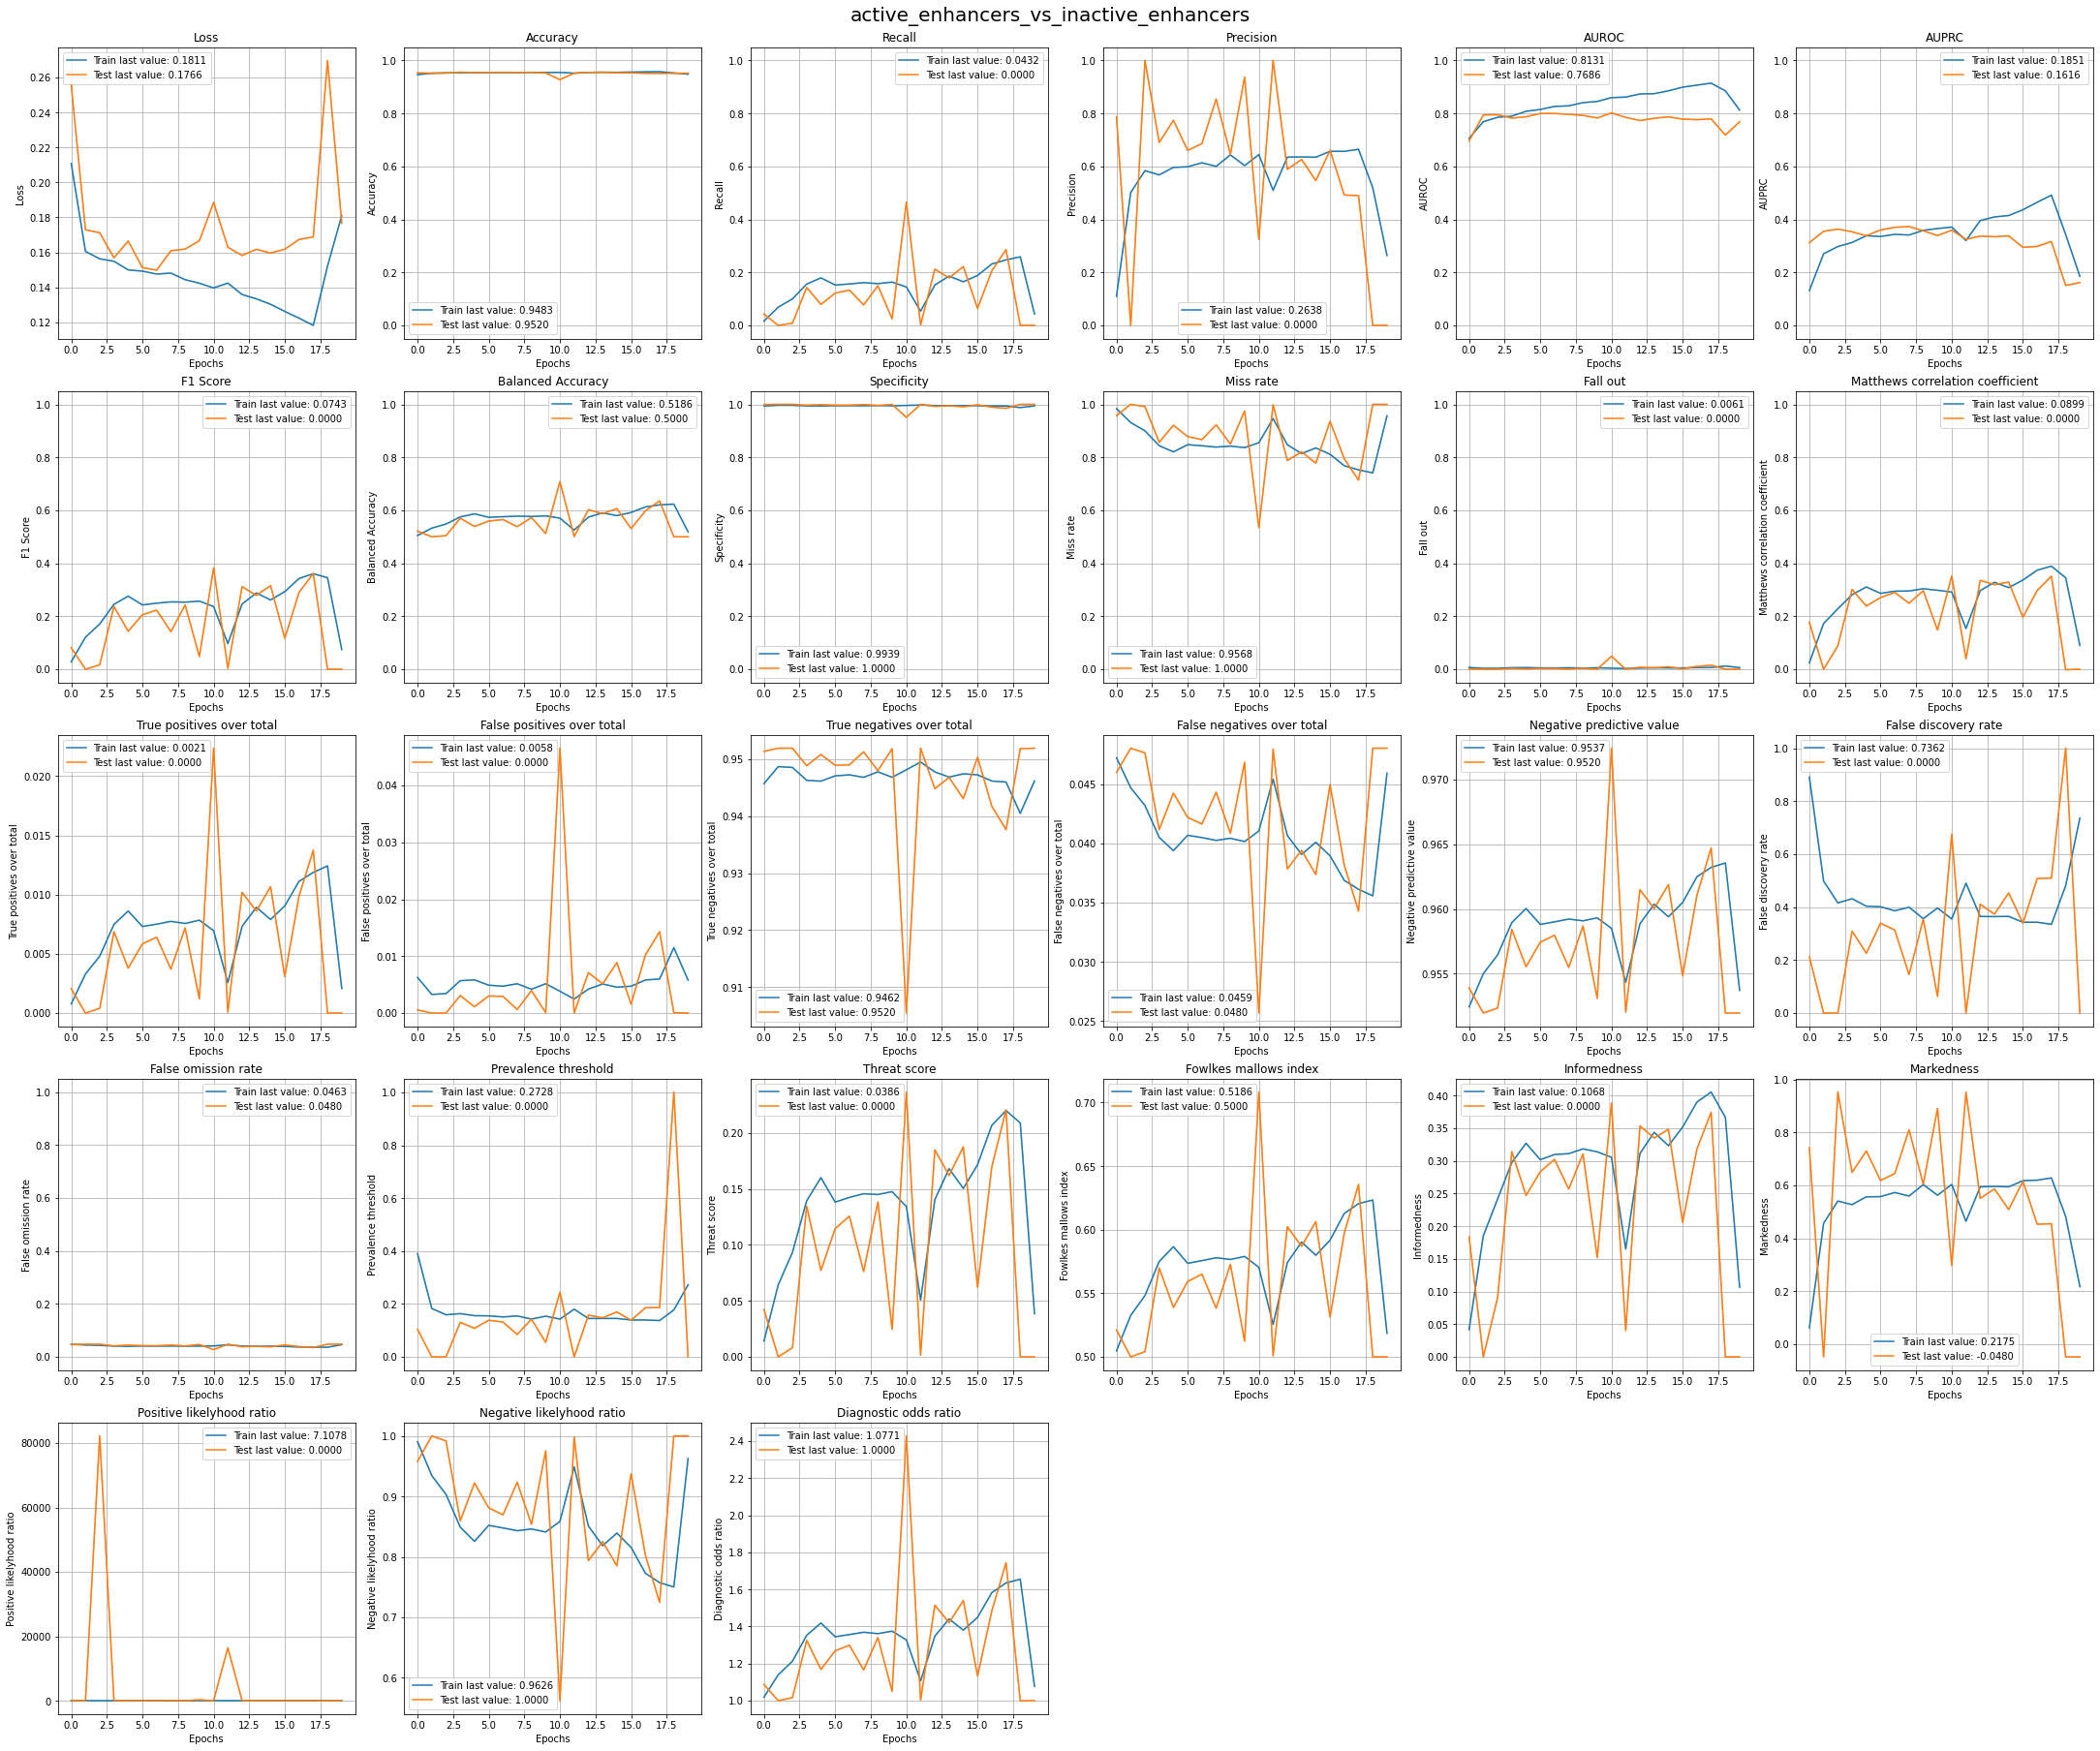

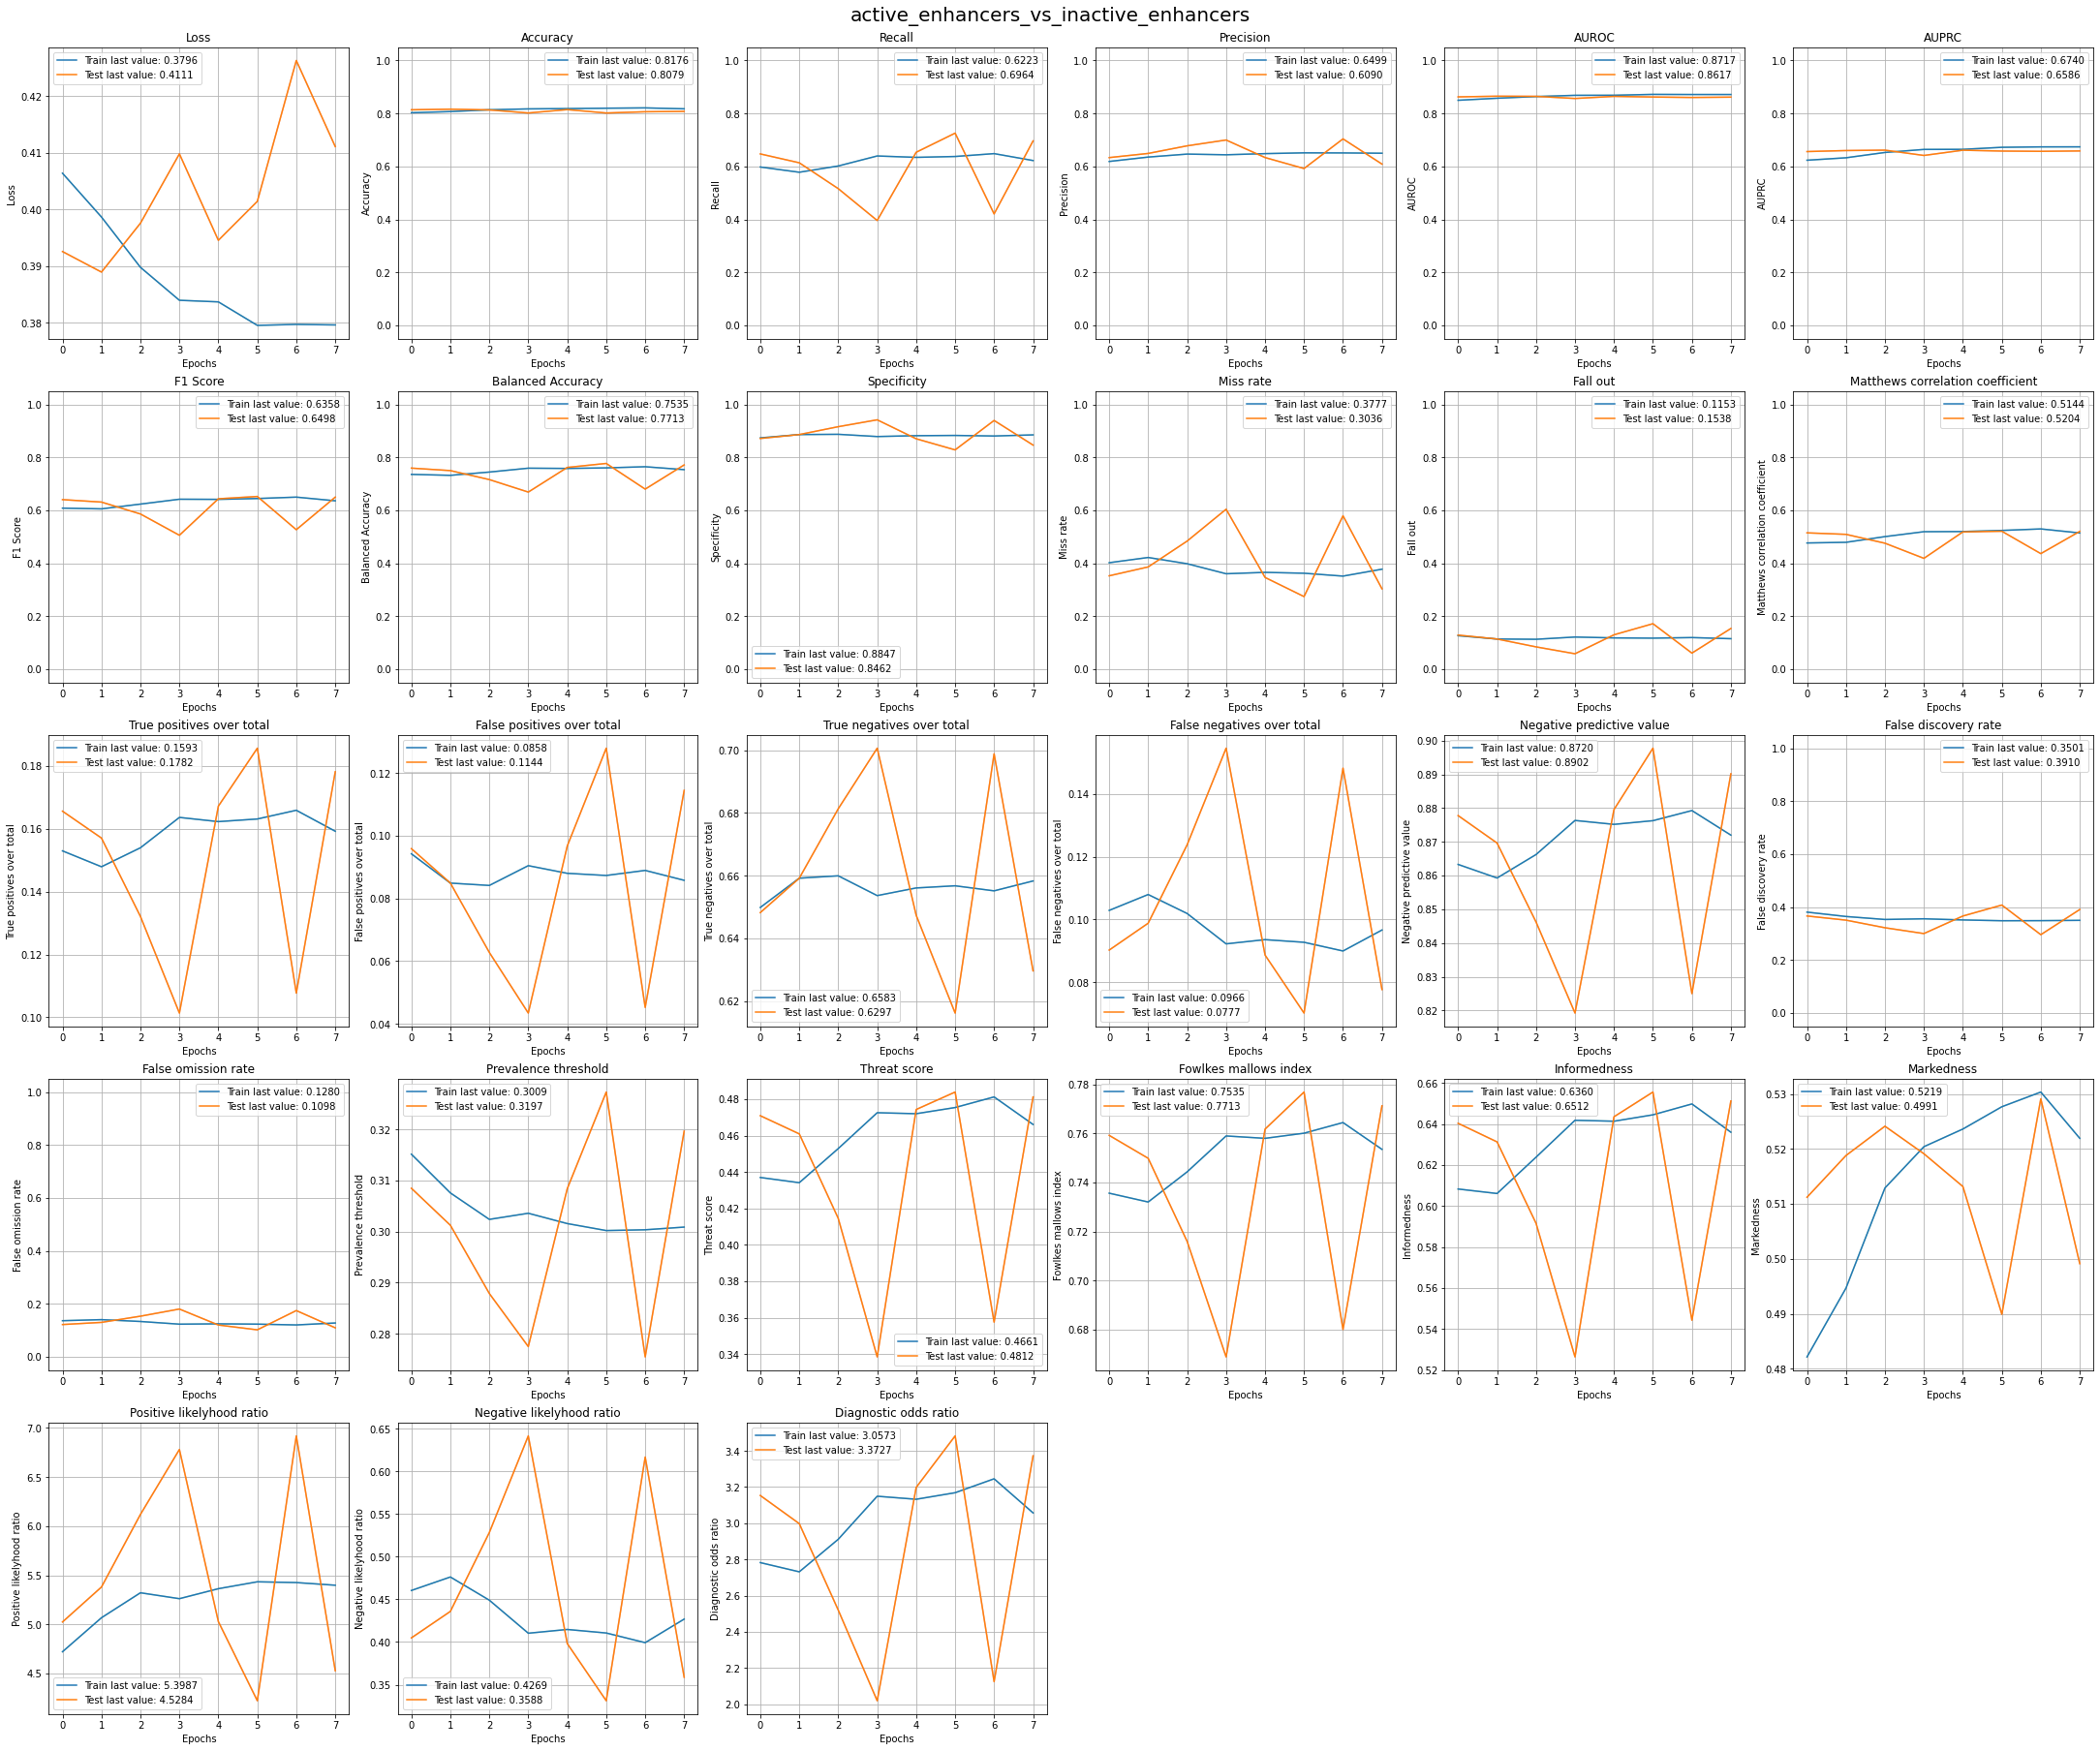

In [7]:
from plot_keras_history import plot_history

aupr_value = {}
for region in list_data.keys(): 
    for index, data in enumerate(list_data[region]):
        aupr_value[index] = data["val_AUPRC"].max()
    max_index = max(aupr_value, key=aupr_value.get)
    plot_history(list_data[region][max_index], title="active_enhancers_vs_inactive_enhancers", graphs_per_row=6, path=f"model_histories_plots/{region}.PNG")

### Save Classification Performace With Timestamp

In [161]:
import datetime

current_timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
all_binary_classification_performance.to_csv(f"all_binary_classification_performance_{current_timestamp}.csv", index=False)

### Load Classification Performace Already Saved

In [4]:
all_binary_classification_performance = pd.read_csv("all_binary_classification_performance_20211225_002858.csv")

In [5]:
all_binary_classification_performance

,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,markedness,positive_likelyhood_ratio,negative_likelyhood_ratio,DOR,run_type,model_name,task,holdout_number,use_feature_selection,elapsed_time
0,0.076860,0.972130,0.553909,0.804543,0.973075,0.740772,0.656105,0.773562,0.993216,0.446091,...,0.782400,81.641998,0.449138,3.416228,train,BinaryClassificationFFNNV1,active_enhancers_vs_inactive_enhancers,0,True,509.42
1,0.220547,0.949435,0.199013,0.441606,0.733976,0.248881,0.274376,0.593157,0.987302,0.800987,...,0.402278,15.672488,0.811289,1.457953,test,BinaryClassificationFFNNV1,active_enhancers_vs_inactive_enhancers,0,True,509.42
2,0.193721,0.952003,0.000000,0.000000,0.508664,0.049881,0.000000,0.500000,1.000000,1.000000,...,-0.047997,0.000000,1.000000,1.000000,train,BinaryClassificationCNNV1,active_enhancers_vs_inactive_enhancers,0,True,48.62
3,0.193911,0.951963,0.000000,0.000000,0.492030,0.046354,0.000000,0.500000,1.000000,1.000000,...,-0.048037,0.000000,1.000000,1.000000,test,BinaryClassificationCNNV1,active_enhancers_vs_inactive_enhancers,0,True,48.62
4,0.072596,0.972940,0.554733,0.823961,0.976503,0.773121,0.663060,0.774379,0.994025,0.445267,...,0.801876,92.835243,0.447944,3.432202,train,MMNNV1,active_enhancers_vs_inactive_enhancers,0,True,210.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0.644646,0.641538,0.842136,0.403884,0.778362,0.518222,0.545939,0.707345,0.572553,0.157864,...,0.317277,1.970153,0.275719,2.416987,test,BinaryClassificationCNNV1,active_promoters_vs_inactive_promoters,9,False,127.88
316,0.396491,0.811661,0.680980,0.620223,0.861832,0.614697,0.649183,0.768791,0.856602,0.319020,...,0.506688,4.748886,0.372425,3.325094,train,MMNNV1,active_promoters_vs_inactive_promoters,9,False,109.85
317,0.405942,0.803274,0.670383,0.604196,0.852179,0.599118,0.635571,0.759679,0.848974,0.329617,...,0.486405,4.438860,0.388253,3.161096,test,MMNNV1,active_promoters_vs_inactive_promoters,9,False,109.85
318,0.414038,0.815003,0.681518,0.627561,0.857039,0.656870,0.653428,0.771213,0.860908,0.318482,...,0.514700,4.899757,0.369937,3.370877,train,BoostedMMNNV1,active_promoters_vs_inactive_promoters,9,False,91.17


In [6]:
all_binary_classification_performance[all_binary_classification_performance.run_type == 'test'].sort_values(by='AUPRC', ascending=False)

,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,markedness,positive_likelyhood_ratio,negative_likelyhood_ratio,DOR,run_type,model_name,task,holdout_number,use_feature_selection,elapsed_time
213,0.391569,0.814937,0.602308,0.649167,0.863213,0.659757,0.624860,0.745184,0.888059,0.397692,...,0.515716,5.380592,0.447821,2.924396,test,MMNNV1,active_promoters_vs_inactive_promoters,3,True,111.73
223,0.411126,0.807879,0.696401,0.608963,0.861691,0.658567,0.649754,0.771308,0.846216,0.303599,...,0.499134,4.528429,0.358773,3.372698,test,BoostedMMNNV1,active_promoters_vs_inactive_promoters,3,False,77.17
181,0.410283,0.811984,0.675861,0.622074,0.863477,0.657032,0.647853,0.767328,0.858796,0.324139,...,0.507188,4.786404,0.377435,3.297900,test,MMNNV1,active_promoters_vs_inactive_promoters,1,True,79.35
177,0.391404,0.813586,0.565336,0.658015,0.863338,0.656656,0.608165,0.732147,0.898957,0.434664,...,0.515442,5.595019,0.483520,2.733389,test,BinaryClassificationFFNNV1,active_promoters_vs_inactive_promoters,1,True,745.34
191,0.392730,0.813435,0.649257,0.631829,0.863364,0.655589,0.640424,0.759576,0.869896,0.350743,...,0.510055,4.990275,0.403202,3.159321,test,BoostedMMNNV1,active_promoters_vs_inactive_promoters,1,False,41.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,0.192783,0.951963,0.000000,0.000000,0.485747,0.045721,0.000000,0.500000,1.000000,1.000000,...,-0.048037,0.000000,1.000000,1.000000,test,BinaryClassificationCNNV1,active_enhancers_vs_inactive_enhancers,6,True,60.63
123,0.194248,0.951963,0.000000,0.000000,0.483508,0.045535,0.000000,0.500000,1.000000,1.000000,...,-0.048037,0.000000,1.000000,1.000000,test,BinaryClassificationCNNV1,active_enhancers_vs_inactive_enhancers,7,False,43.76
27,0.193269,0.951963,0.000000,0.000000,0.475472,0.045519,0.000000,0.500000,1.000000,1.000000,...,-0.048037,0.000000,1.000000,1.000000,test,BinaryClassificationCNNV1,active_enhancers_vs_inactive_enhancers,1,False,41.94
51,0.193168,0.951963,0.000000,0.000000,0.464798,0.043798,0.000000,0.500000,1.000000,1.000000,...,-0.048037,0.000000,1.000000,1.000000,test,BinaryClassificationCNNV1,active_enhancers_vs_inactive_enhancers,3,True,43.18


### Adapting Dataframe, Generate And Save Plotbars

In [8]:
all_binary_classification_performance["use_feature_selection"] = [
    "Feature Selection" if use_selection else "No Feature Selection"
    for use_selection in all_binary_classification_performance["use_feature_selection"]
]

all_performance = all_binary_classification_performance.drop(columns=["holdout_number"])

Rendering barplots: 100%|██████████| 4/4 [00:14<00:00,  3.73s/it]


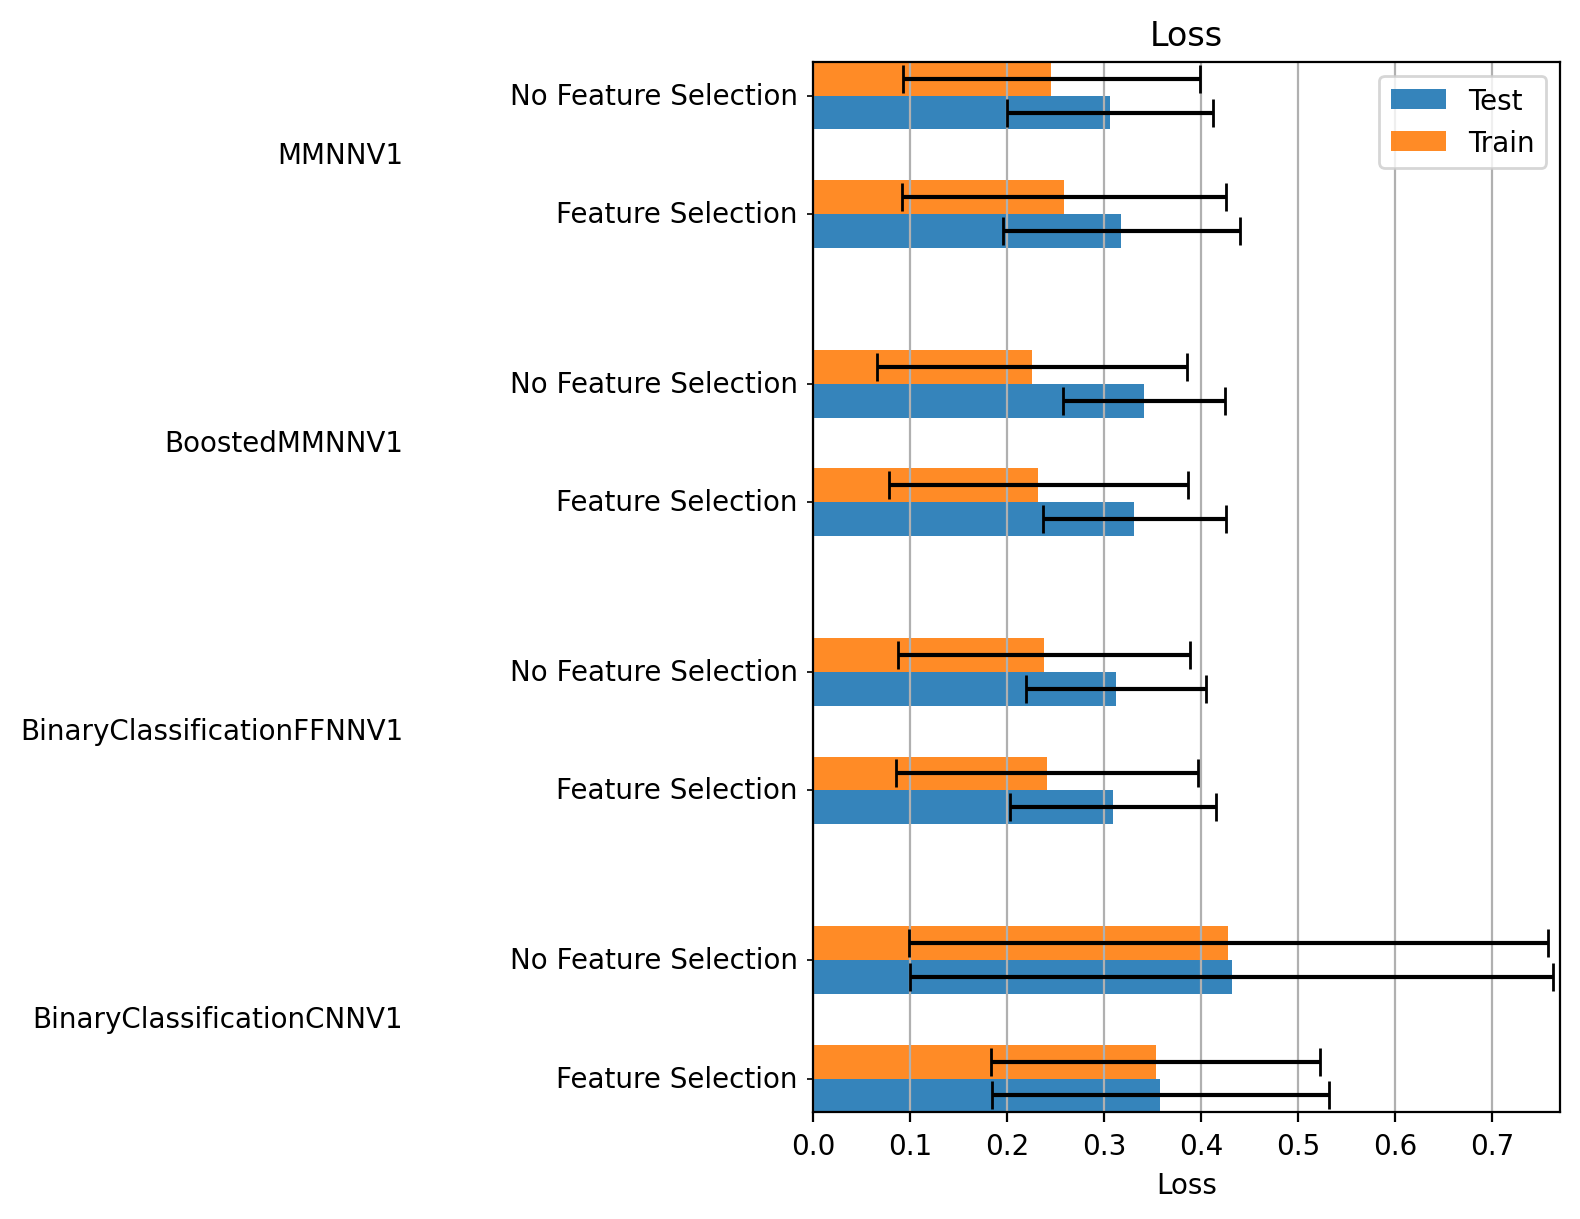

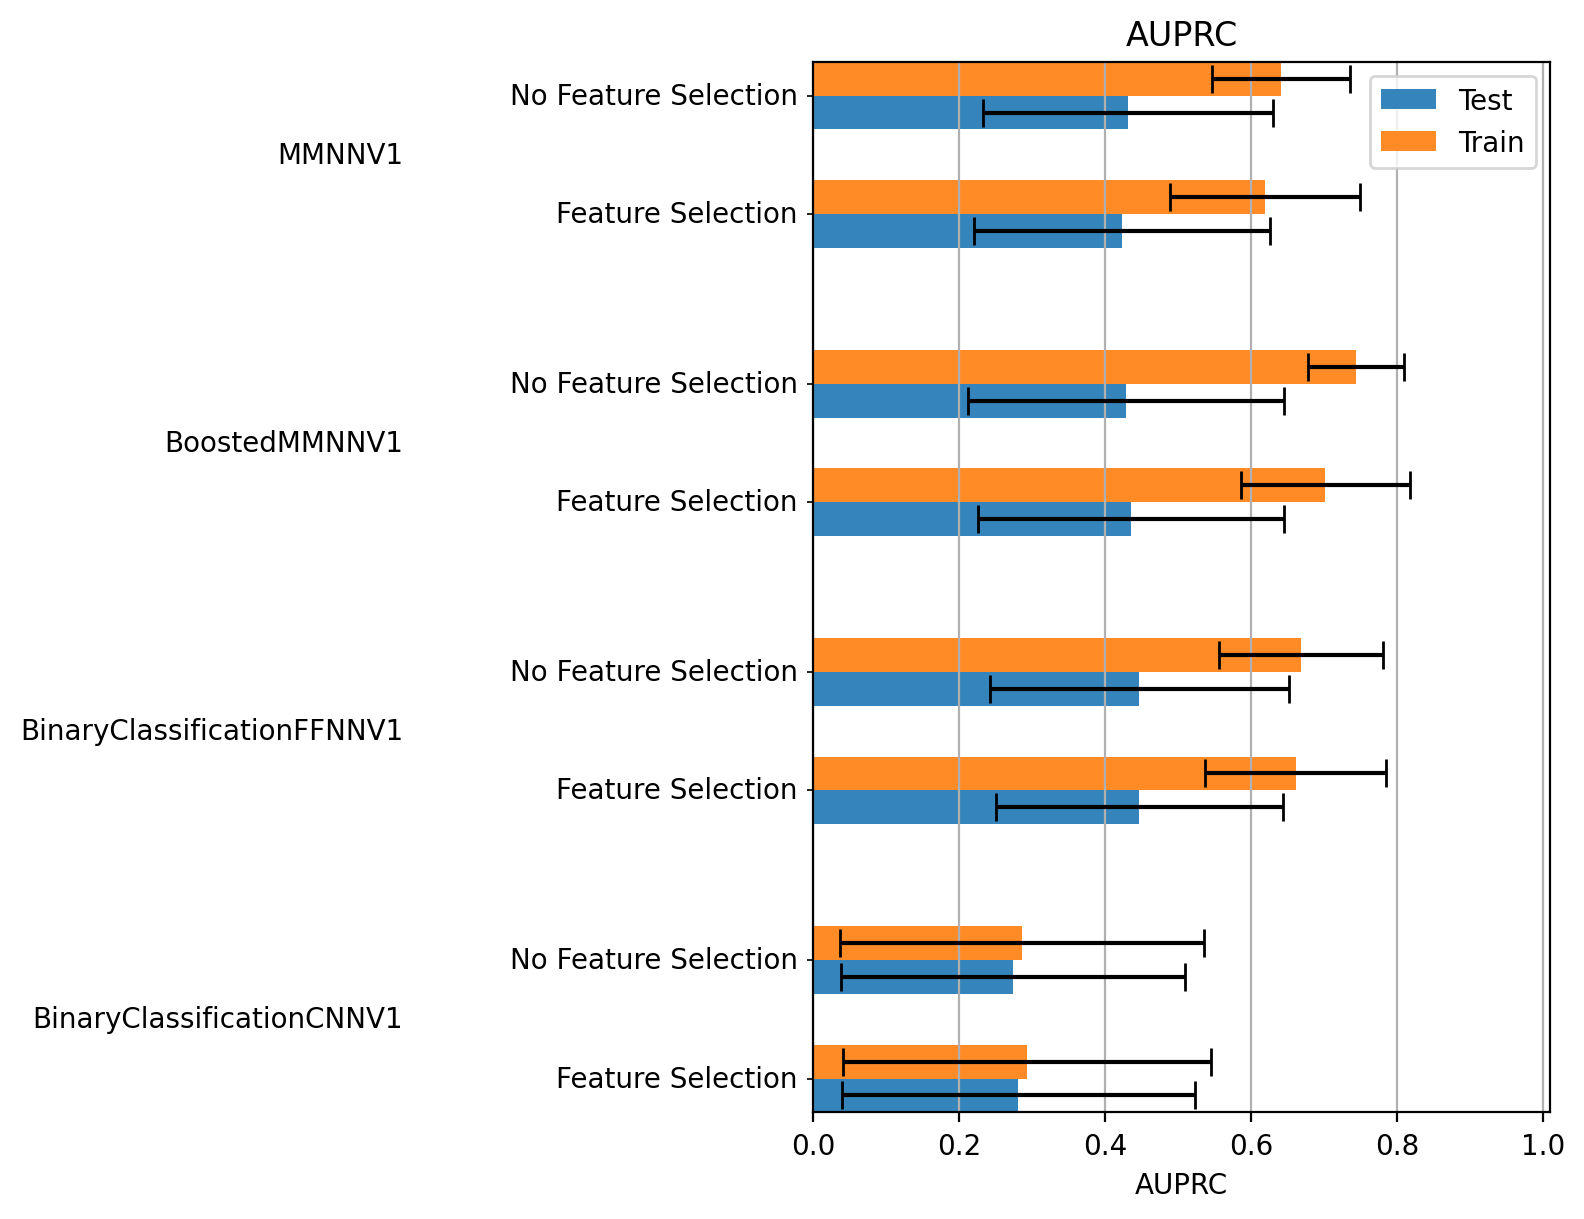

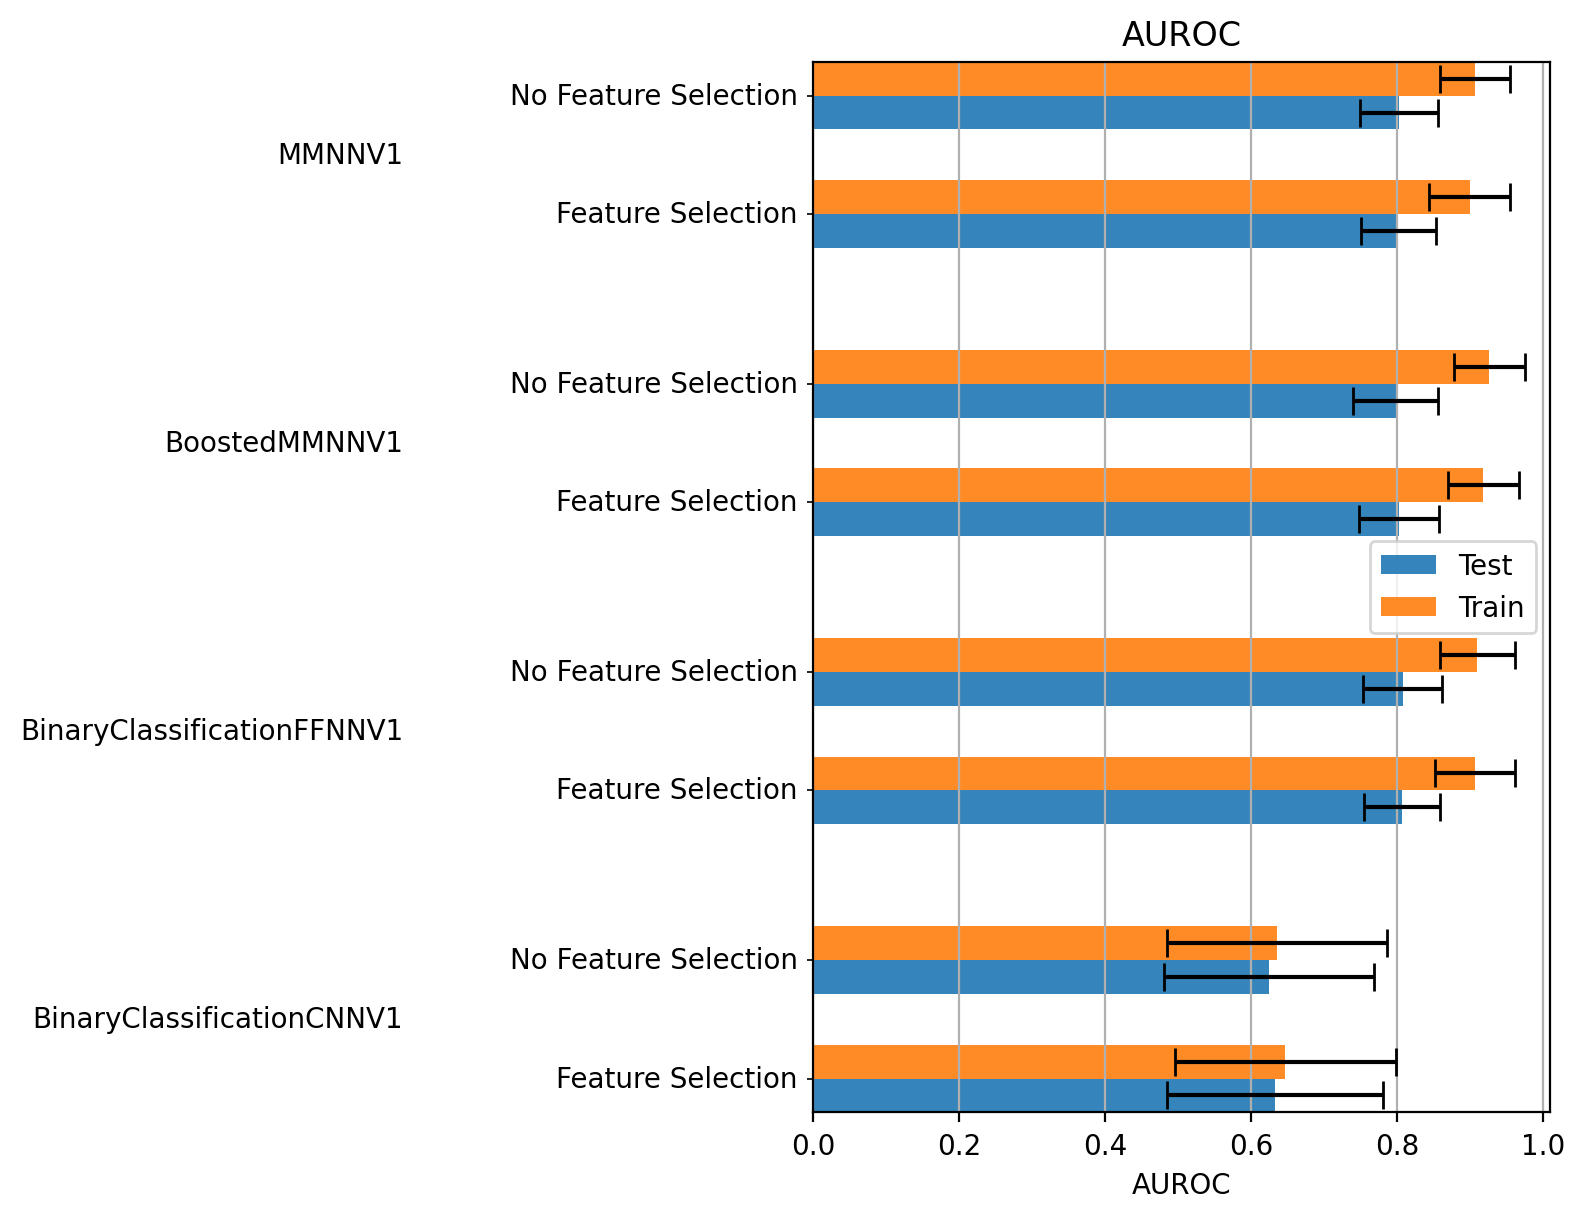

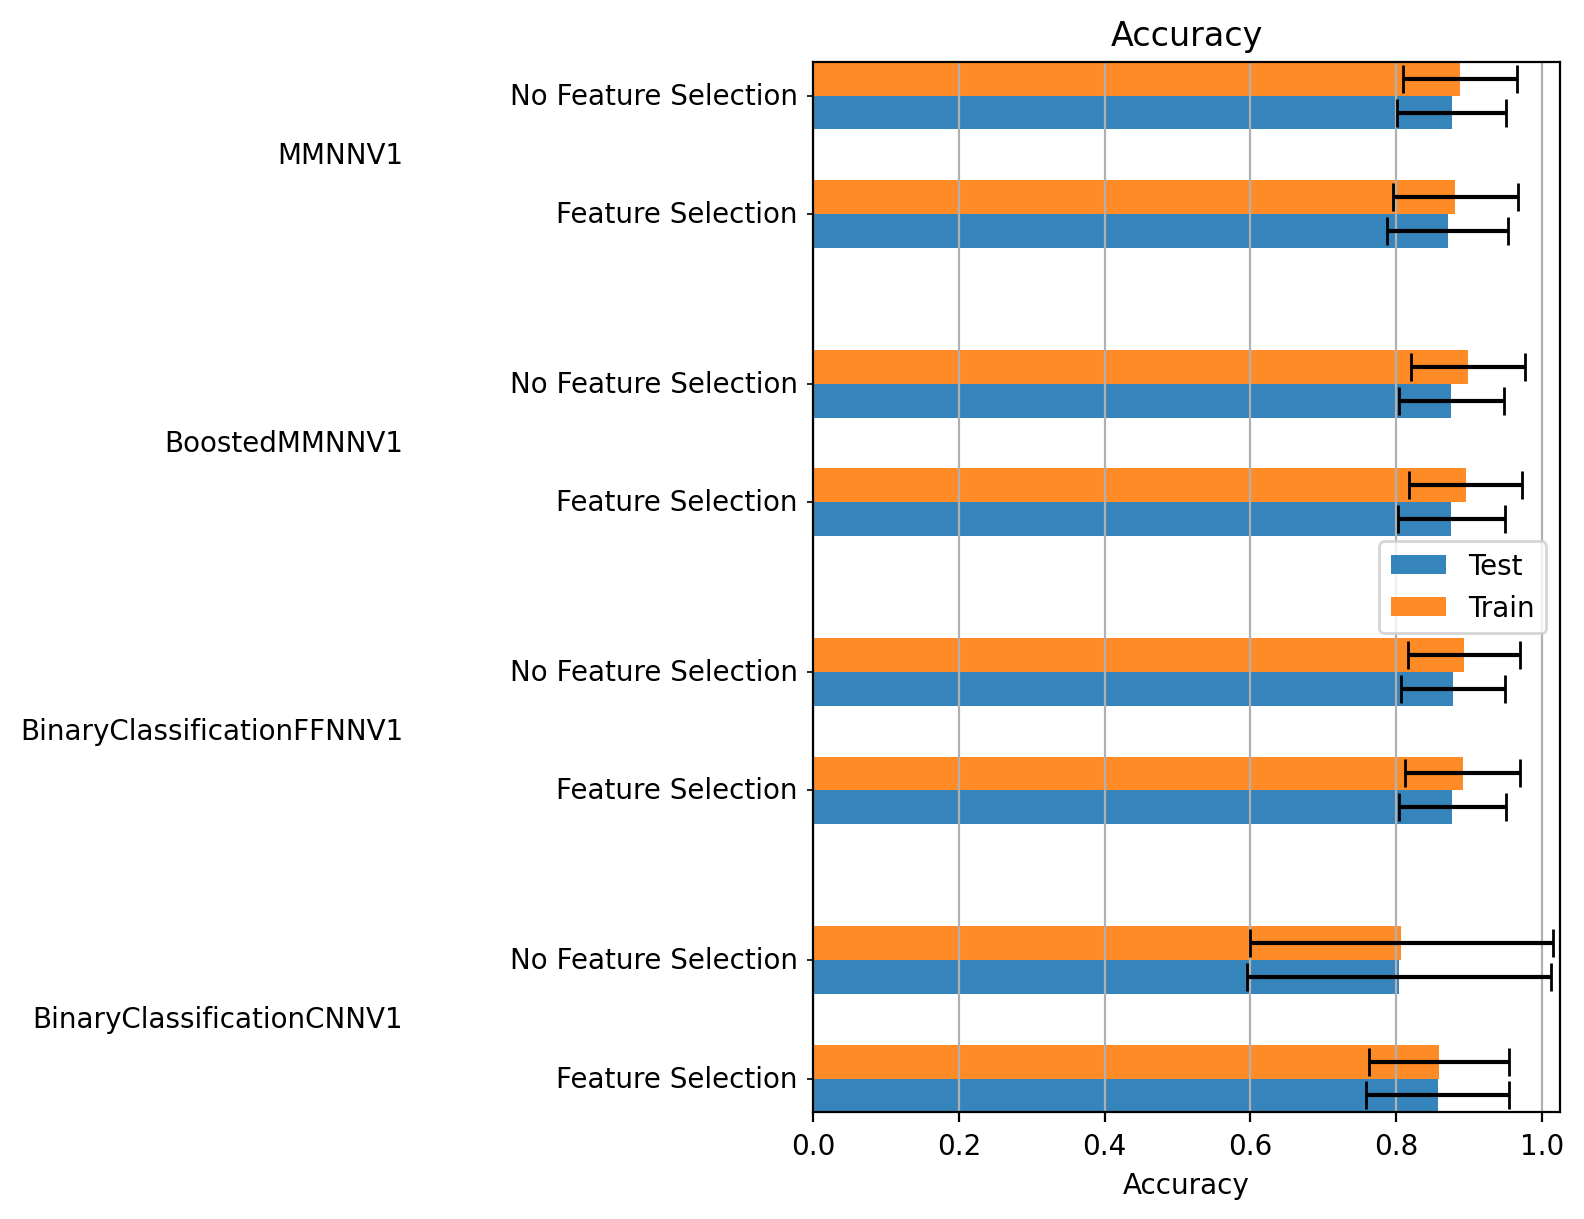

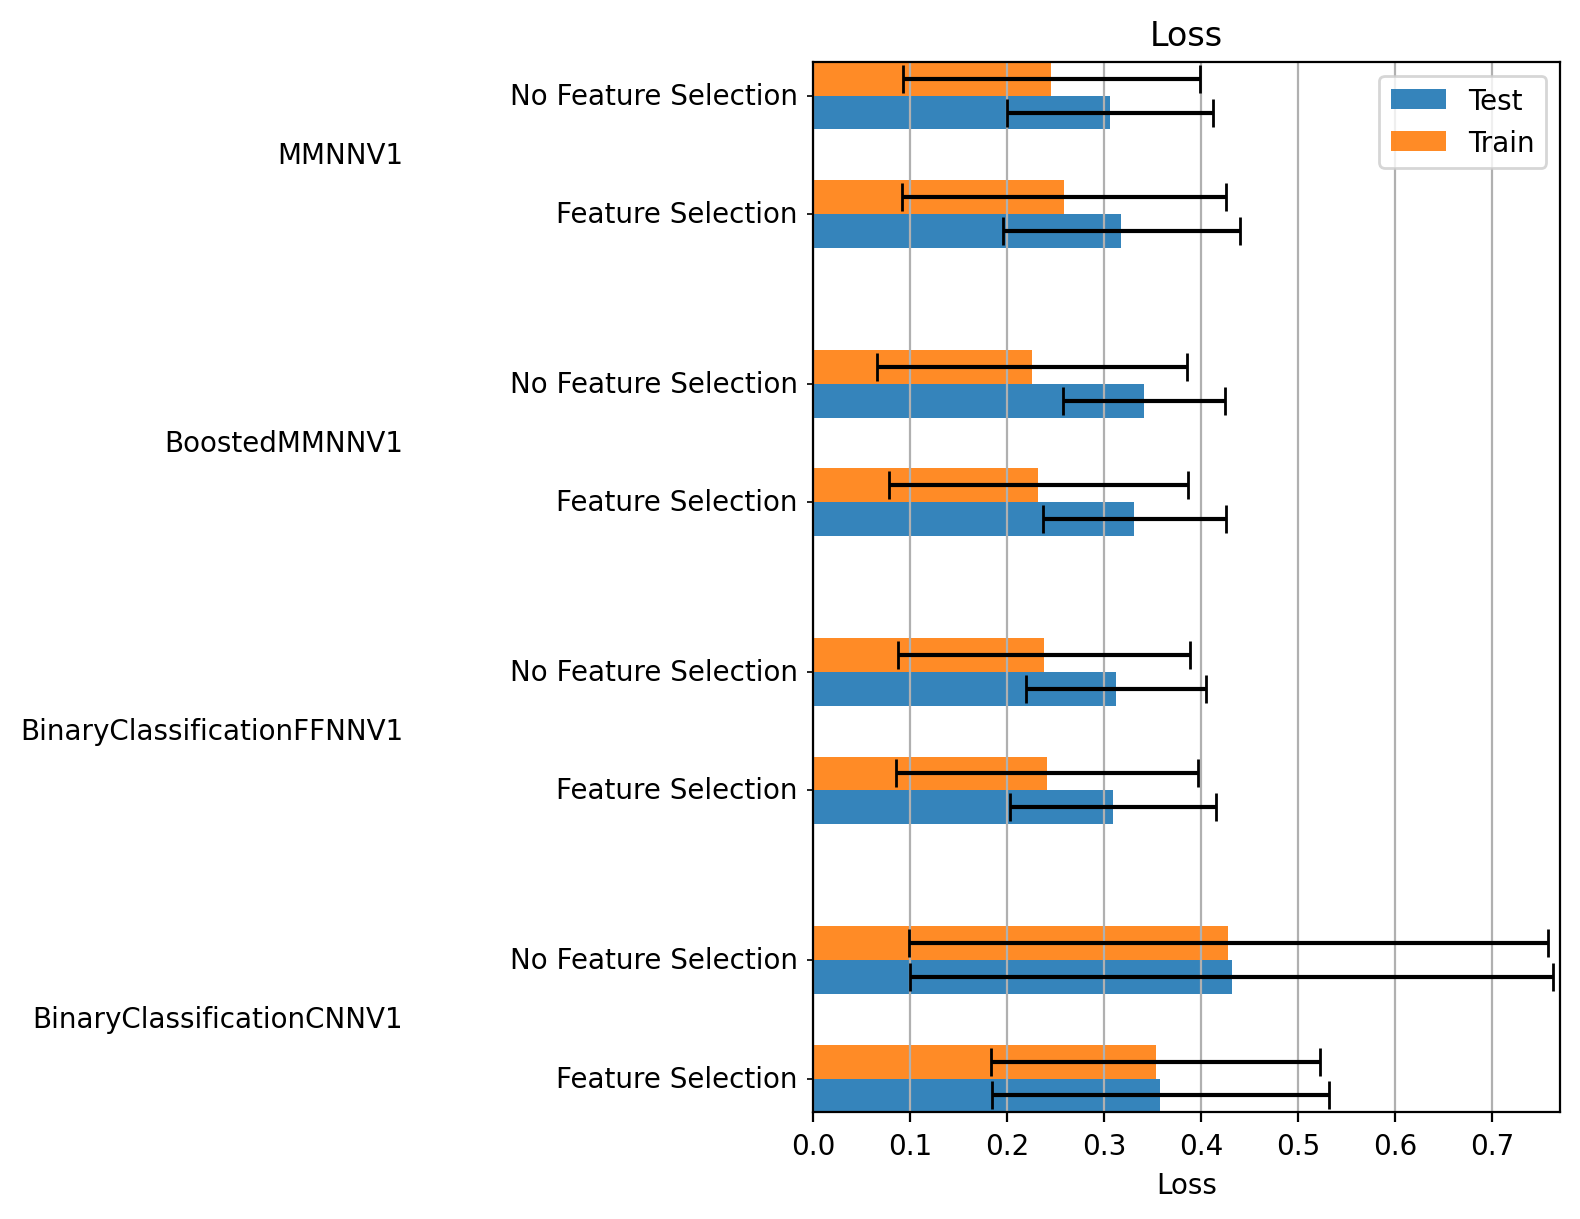

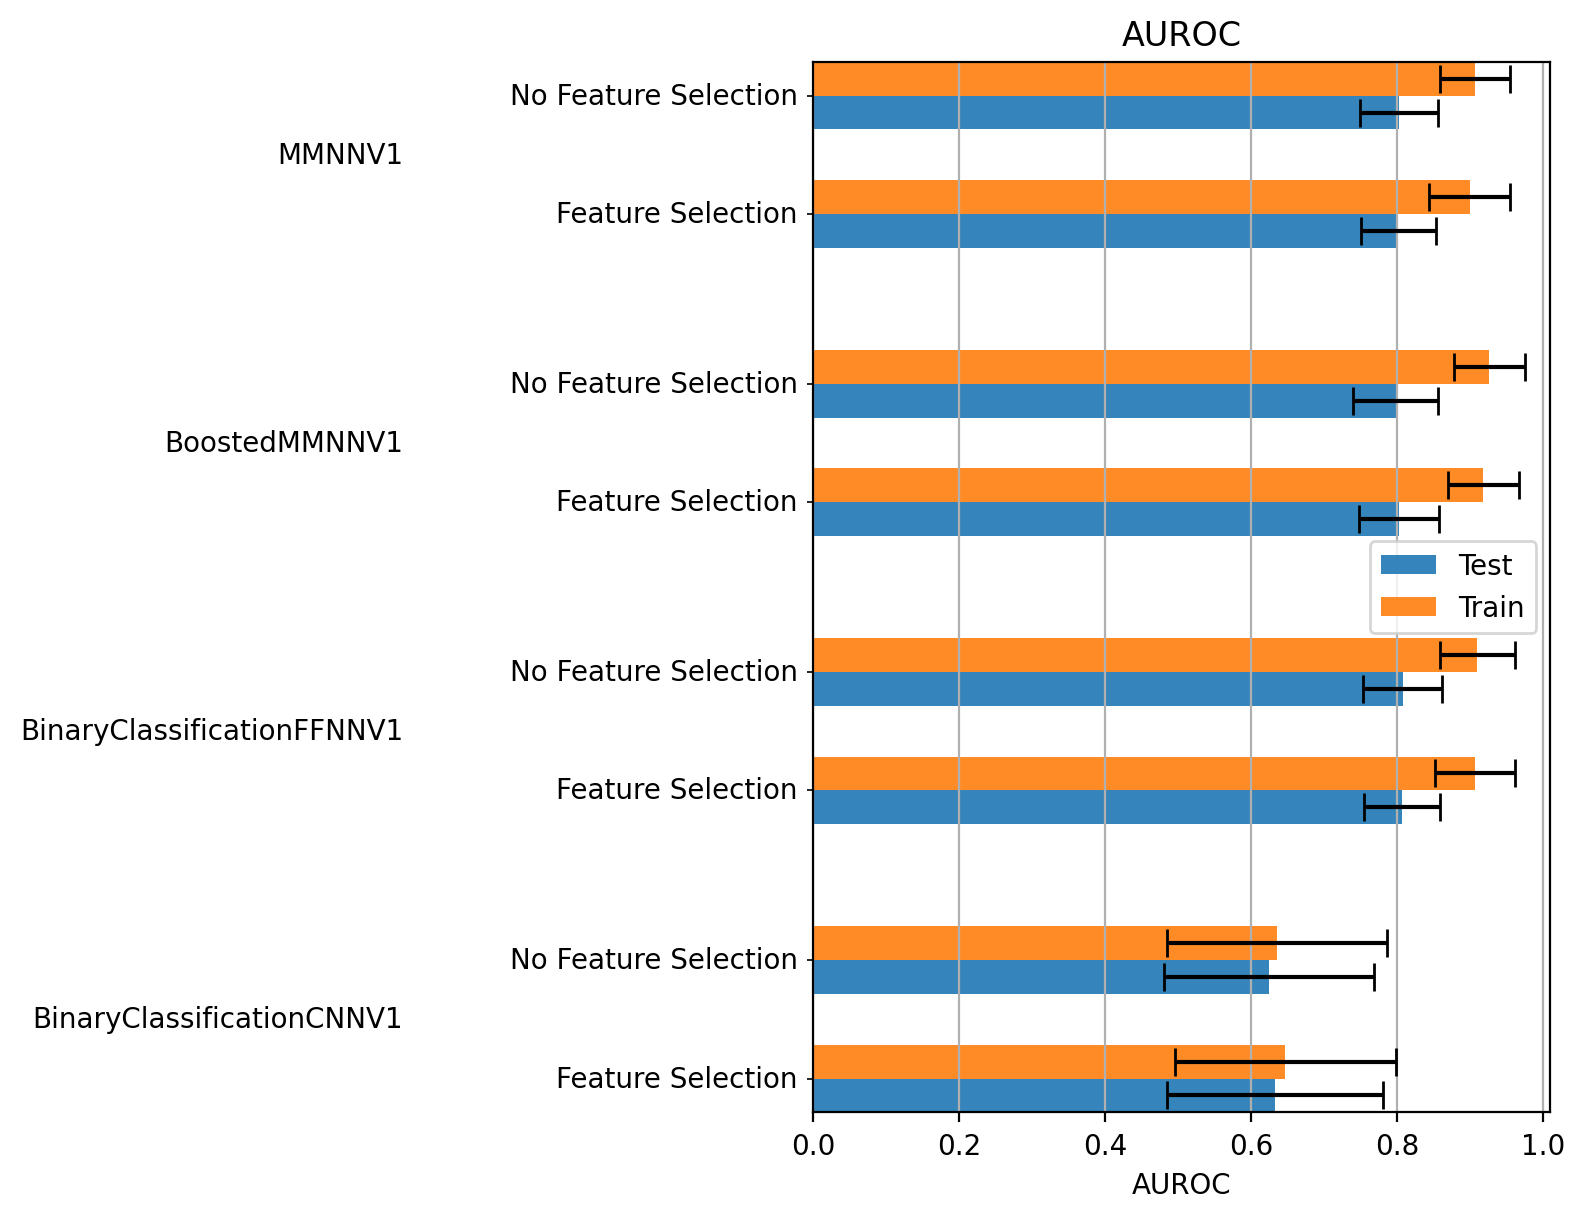

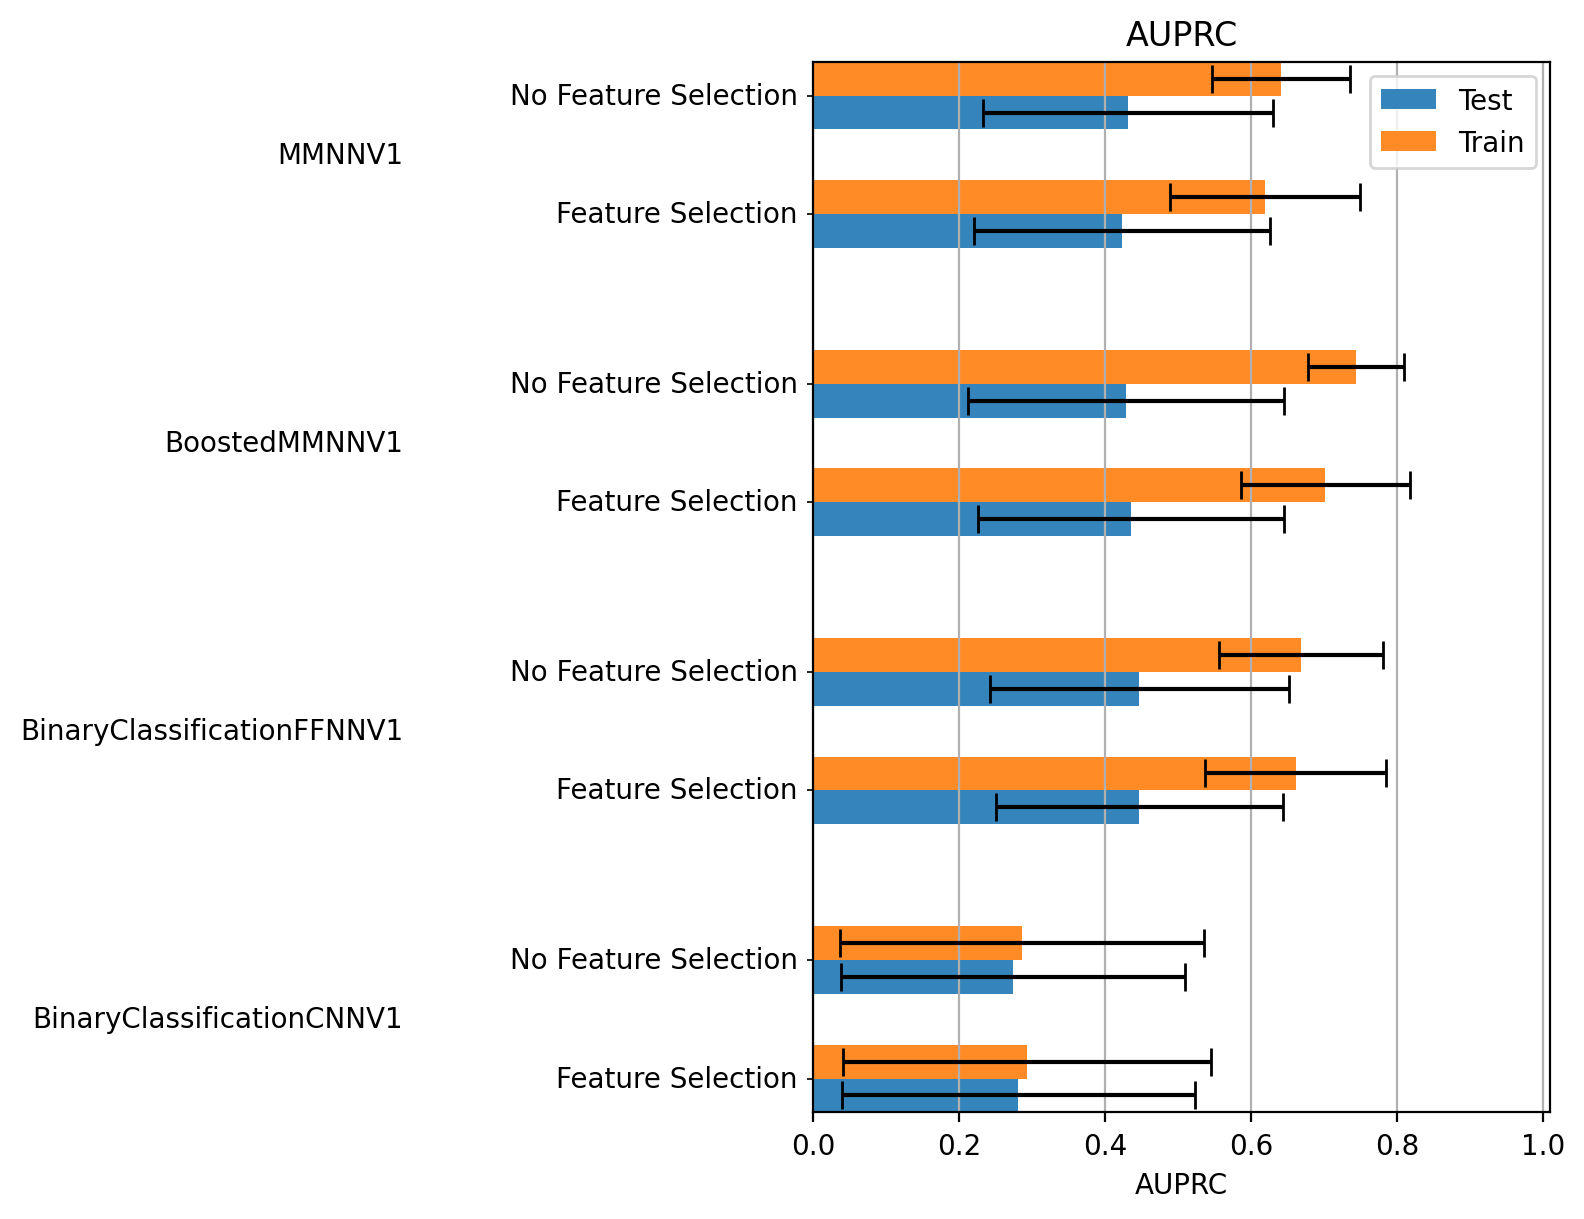

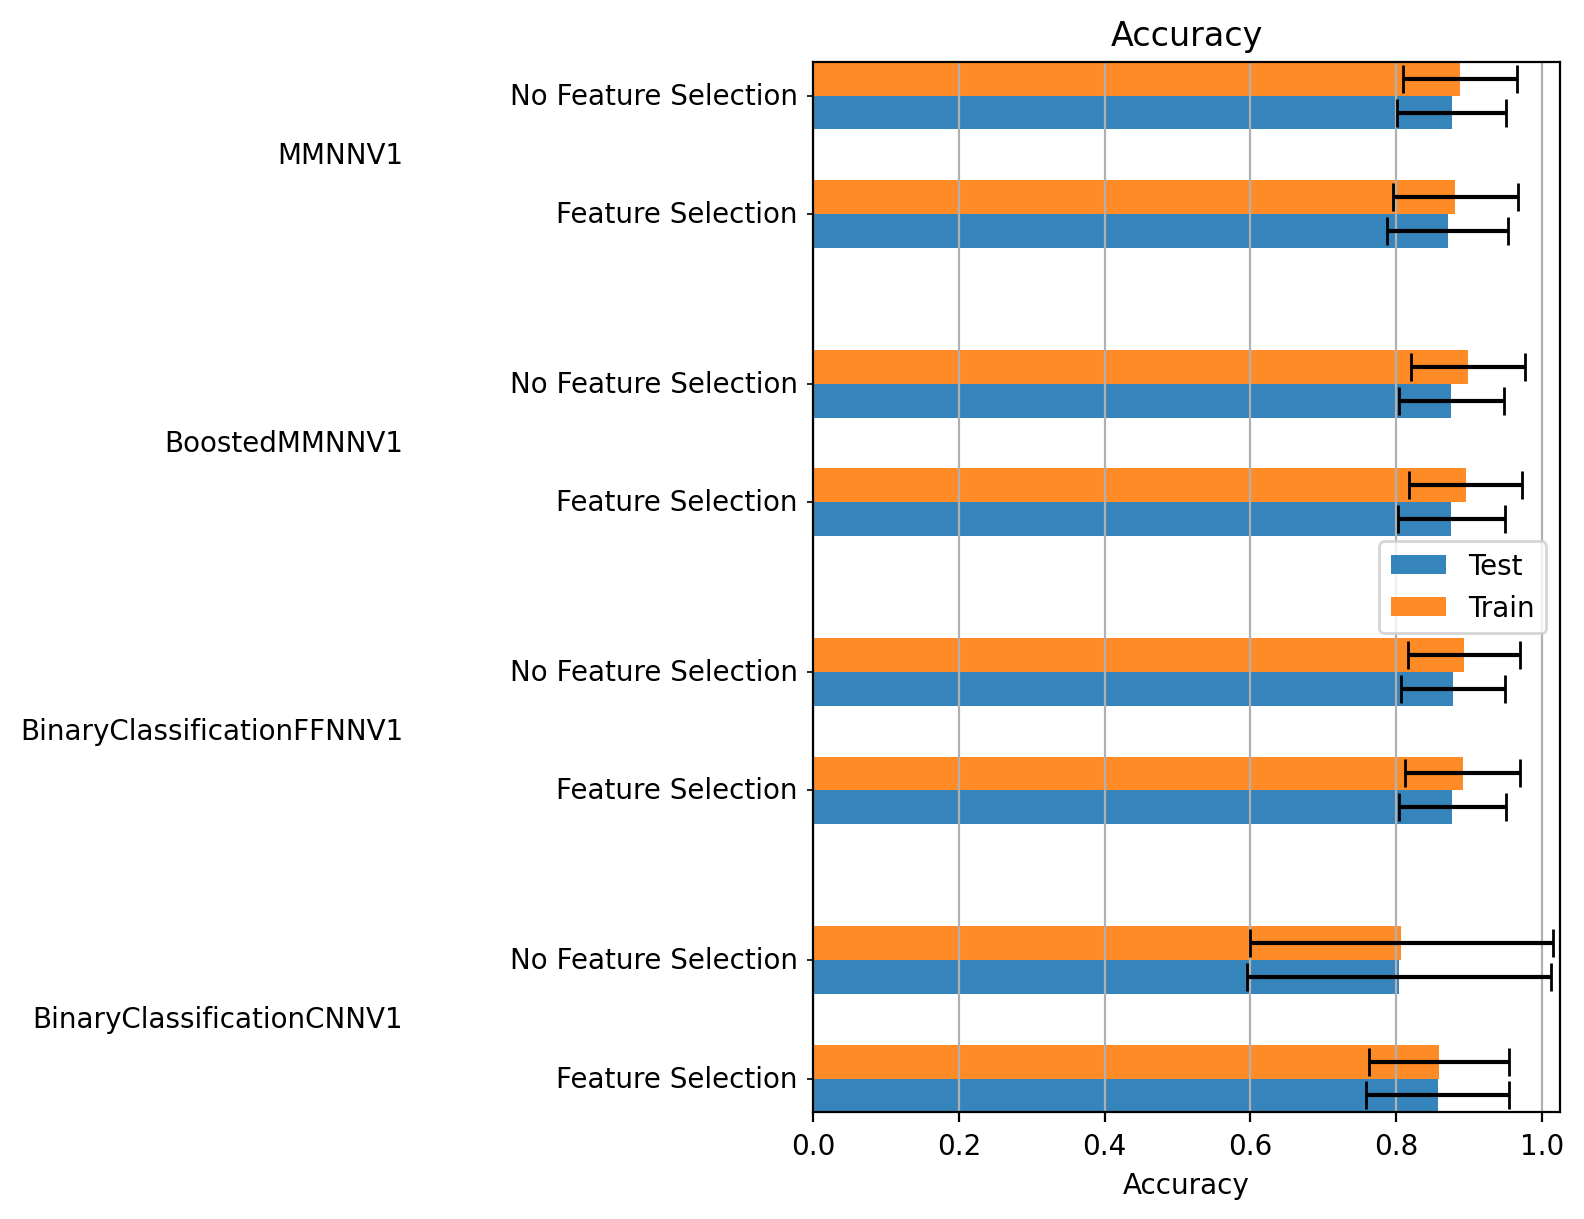

In [38]:
from utils.data_processing import generate_plotbars

generate_plotbars(all_performance)

In [54]:
from scipy.stats import wilcoxon
from numpy import asarray

for model in all_binary_classification_performance.model_name.unique():
    model_performance = all_performance[(all_performance.model_name == model) & (all_performance.run_type == "test") & (all_performance.task == "active_enhancers_vs_inactive_enhancers")]
    performance_with_feature_selection = model_performance[
        all_performance.use_feature_selection == "Feature Selection"
    ]
    performance_without_feature_selection = model_performance[
        all_performance.use_feature_selection == "No Feature Selection"
    ]

    for metric in ("AUPRC", "AUROC", "accuracy"):
            x, y = map(asarray, (performance_with_feature_selection[metric], performance_without_feature_selection[metric]))
            d = x-y
            print(len(d))
    print("="*100)

10
10
10
10
10
10
10
10
10
10
10
10


c:\Users\Bibbo\Documents\VsCode\Bioinformatica\bioinformatics_project\venv\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
c:\Users\Bibbo\Documents\VsCode\Bioinformatica\bioinformatics_project\venv\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [53]:
y

array([0.94659084, 0.94603777, 0.948645  , 0.94714385, 0.94185036,
       0.9431935 , 0.94627482, 0.94477361, 0.94643283, 0.94832897])

In [ ]:
 print(
                task,
                model,
                metric,
                wilcoxon(performance_with_feature_selection[metric], performance_without_feature_selection[metric])
            )

In [26]:
model_performance

,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,informedness,markedness,positive_likelyhood_ratio,negative_likelyhood_ratio,DOR,run_type,model_name,task,use_feature_selection,elapsed_time
7,0.239956,0.944932,0.200658,0.366366,0.747795,0.219734,0.259299,0.591573,0.982488,0.799342,...,0.271135,0.326931,11.458356,0.813589,1.448418,test,BoostedMMNNV1,active_enhancers_vs_inactive_enhancers,Feature Selection,89.09
15,0.235950,0.946591,0.167763,0.375000,0.745171,0.205097,0.231818,0.576827,0.985891,0.832237,...,0.250821,0.334144,11.890377,0.844147,1.363100,test,BoostedMMNNV1,active_enhancers_vs_inactive_enhancers,No Feature Selection,49.29
23,0.213553,0.947697,0.139803,0.379464,0.740632,0.199816,0.204327,0.564133,0.988464,0.860197,...,0.230326,0.337399,12.118471,0.870237,1.294279,test,BoostedMMNNV1,active_enhancers_vs_inactive_enhancers,Feature Selection,57.13
31,0.278002,0.946038,0.136513,0.344398,0.726379,0.185402,0.195524,0.561700,0.986887,0.863487,...,0.216829,0.302114,10.410345,0.874960,1.281542,test,BoostedMMNNV1,active_enhancers_vs_inactive_enhancers,No Feature Selection,73.19
39,0.172626,0.951805,0.000000,0.000000,0.754558,0.240183,0.000000,0.499917,0.999834,1.000000,...,0.000000,-0.048044,0.000000,1.000166,0.999668,test,BoostedMMNNV1,active_enhancers_vs_inactive_enhancers,Feature Selection,51.45
47,0.228650,0.948645,0.169408,0.415323,0.743223,0.235724,0.240654,0.578687,0.987966,0.830592,...,0.265253,0.374626,14.077095,0.840709,1.373531,test,BoostedMMNNV1,active_enhancers_vs_inactive_enhancers,No Feature Selection,100.79
55,0.156014,0.954650,0.110197,0.670000,0.804942,0.327856,0.189266,0.553729,0.997261,0.889803,...,0.271721,0.626916,40.233929,0.892246,1.240792,test,BoostedMMNNV1,active_enhancers_vs_inactive_enhancers,Feature Selection,36.41
63,0.341131,0.947144,0.199013,0.399340,0.715451,0.222085,0.265642,0.591954,0.984895,0.800987,...,0.281911,0.359920,13.175241,0.813271,1.450704,test,BoostedMMNNV1,active_enhancers_vs_inactive_enhancers,No Feature Selection,43.37
71,0.248898,0.950304,0.190789,0.458498,0.750623,0.261833,0.269454,0.589710,0.988630,0.809211,...,0.295764,0.418833,16.779579,0.818517,1.437298,test,BoostedMMNNV1,active_enhancers_vs_inactive_enhancers,Feature Selection,82.30
79,0.379950,0.941850,0.197368,0.326087,0.730891,0.197366,0.245902,0.588393,0.979417,0.802632,...,0.253691,0.286377,9.589035,0.819499,1.429501,test,BoostedMMNNV1,active_enhancers_vs_inactive_enhancers,No Feature Selection,179.66


In [60]:
from scipy.stats import wilcoxon

for task in all_binary_classification_performance.task.unique():
    for model in all_binary_classification_performance.model_name.unique():
        model_performance = all_performance[(all_performance.model_name == model) & (all_performance.run_type == "test") & (all_performance.task == task)]
        performance_with_feature_selection = model_performance[
            all_performance.use_feature_selection == "Feature Selection"
        ]
        performance_without_feature_selection = model_performance[
            all_performance.use_feature_selection == "No Feature Selection"
        ]

        for metric in ("AUPRC", "AUROC", "accuracy"):
            print(
                task,
                model,
                metric,
                wilcoxon(x=performance_with_feature_selection[metric], y=performance_without_feature_selection[metric], zero_method="zsplit")
            )
        print("="*100)

active_enhancers_vs_inactive_enhancers BinaryClassificationFFNNV1 AUPRC WilcoxonResult(statistic=25.0, pvalue=0.845703125)
active_enhancers_vs_inactive_enhancers BinaryClassificationFFNNV1 AUROC WilcoxonResult(statistic=26.0, pvalue=0.921875)
active_enhancers_vs_inactive_enhancers BinaryClassificationFFNNV1 accuracy WilcoxonResult(statistic=16.0, pvalue=0.275390625)
active_enhancers_vs_inactive_enhancers BinaryClassificationCNNV1 AUPRC WilcoxonResult(statistic=21.0, pvalue=0.556640625)
active_enhancers_vs_inactive_enhancers BinaryClassificationCNNV1 AUROC WilcoxonResult(statistic=22.0, pvalue=0.625)
active_enhancers_vs_inactive_enhancers BinaryClassificationCNNV1 accuracy WilcoxonResult(statistic=27.5, pvalue=1.0)
active_enhancers_vs_inactive_enhancers MMNNV1 AUPRC WilcoxonResult(statistic=26.0, pvalue=0.921875)
active_enhancers_vs_inactive_enhancers MMNNV1 AUROC WilcoxonResult(statistic=23.0, pvalue=0.6953125)
active_enhancers_vs_inactive_enhancers MMNNV1 accuracy WilcoxonResult(stati

c:\Users\Bibbo\Documents\VsCode\Bioinformatica\bioinformatics_project\venv\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
c:\Users\Bibbo\Documents\VsCode\Bioinformatica\bioinformatics_project\venv\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [61]:
from scipy.stats import wilcoxon

for task in all_binary_classification_performance.task.unique():
    for model in all_binary_classification_performance.model_name.unique():
        model_performance = all_performance[(all_performance.model_name == model) & (all_performance.run_type == "test") & (all_performance.task == task)]
        performance_with_feature_selection = model_performance[
            all_performance.use_feature_selection == "Feature Selection"
        ]
        performance_without_feature_selection = model_performance[
            all_performance.use_feature_selection == "No Feature Selection"
        ]
        print(f"Task {task}")
        for metric in ("AUPRC", "AUROC", "accuracy"):
            try:
                    _, p_value = wilcoxon(
                        performance_with_feature_selection[metric],
                        performance_without_feature_selection[metric],
                        zero_method="zsplit")
                    # when p_value is less than the significance level, then the null
                    # hypothesis is rejected and the model with greater mean for the
                    # current metric is better than the other.
                    if p_value < 0.01:
                        if performance_with_feature_selection.mean() > performance_without_feature_selection.mean():
                            print(f"{model} shows better results for {metric} with feature selection.")
                        else:
                            print(f"{model} shows better results for {metric} without feature selection.")
                    else:
                        print(f"{model} shows statistically Indistinguishable results for {metric} with and without feature selection. p_value: {p_value}")
            except ValueError:
                # this situation occurs when the matric are exactly the same.
                print(f"{model} has the same values for {metric}")
        print("="*130)

Task active_enhancers_vs_inactive_enhancers
BinaryClassificationFFNNV1 shows statistically Indistinguishable results for AUPRC with and without feature selection. p_value: 0.845703125
BinaryClassificationFFNNV1 shows statistically Indistinguishable results for AUROC with and without feature selection. p_value: 0.921875
BinaryClassificationFFNNV1 shows statistically Indistinguishable results for accuracy with and without feature selection. p_value: 0.275390625
Task active_enhancers_vs_inactive_enhancers
BinaryClassificationCNNV1 shows statistically Indistinguishable results for AUPRC with and without feature selection. p_value: 0.556640625
BinaryClassificationCNNV1 shows statistically Indistinguishable results for AUROC with and without feature selection. p_value: 0.625
BinaryClassificationCNNV1 shows statistically Indistinguishable results for accuracy with and without feature selection. p_value: 1.0
Task active_enhancers_vs_inactive_enhancers
MMNNV1 shows statistically Indistinguishab

c:\Users\Bibbo\Documents\VsCode\Bioinformatica\bioinformatics_project\venv\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
c:\Users\Bibbo\Documents\VsCode\Bioinformatica\bioinformatics_project\venv\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


### Graphical Evaluation Of The Trend Of Elapsed Time Spend During The Execution Using Boruta For Each Tasks Respect To The AUPRC Metric And Holdouts.

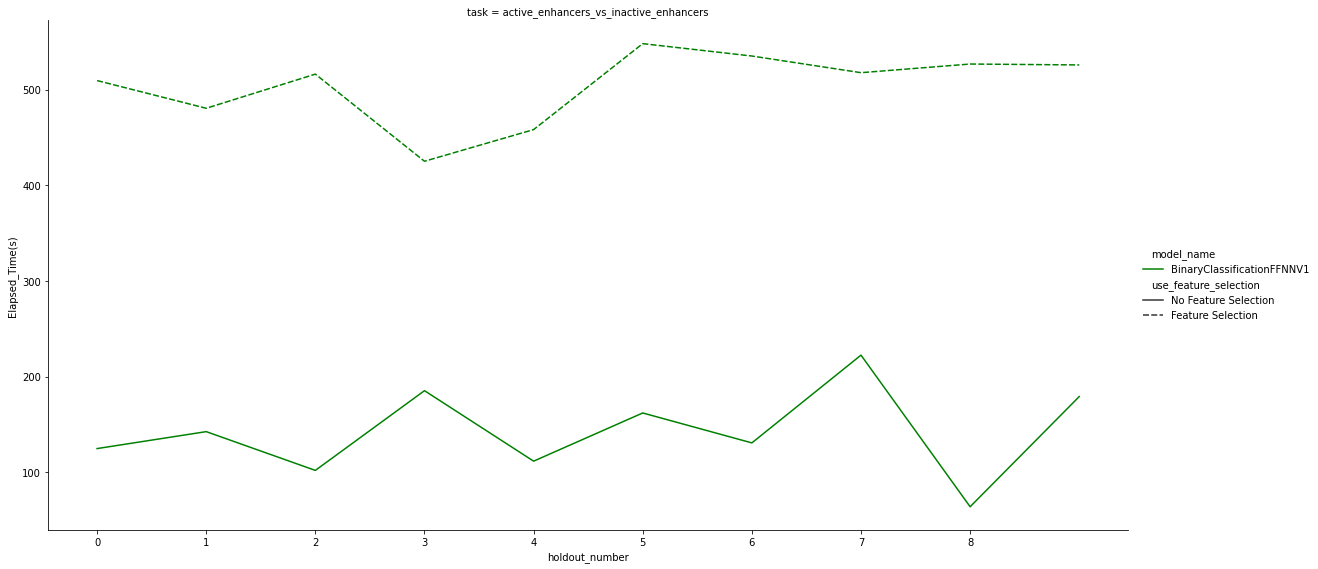

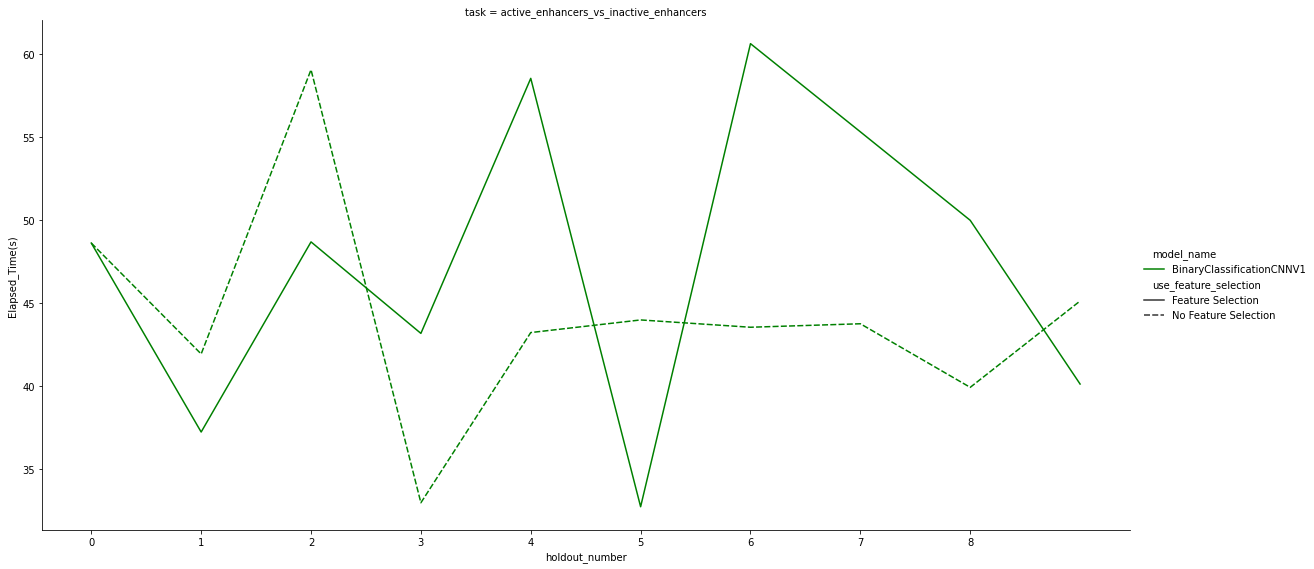

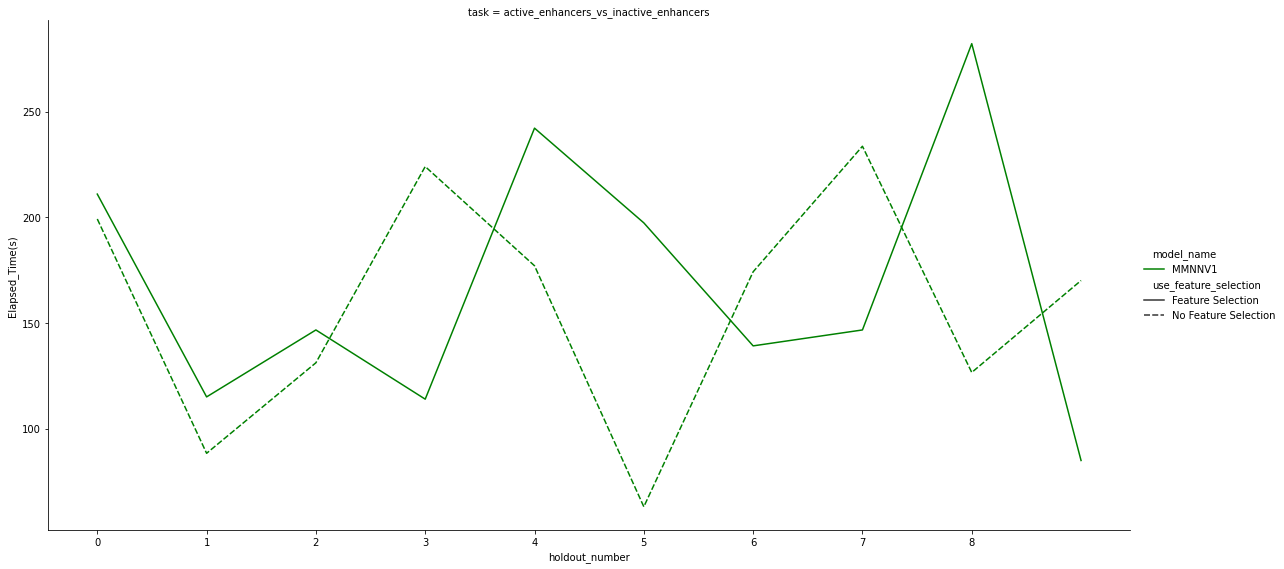

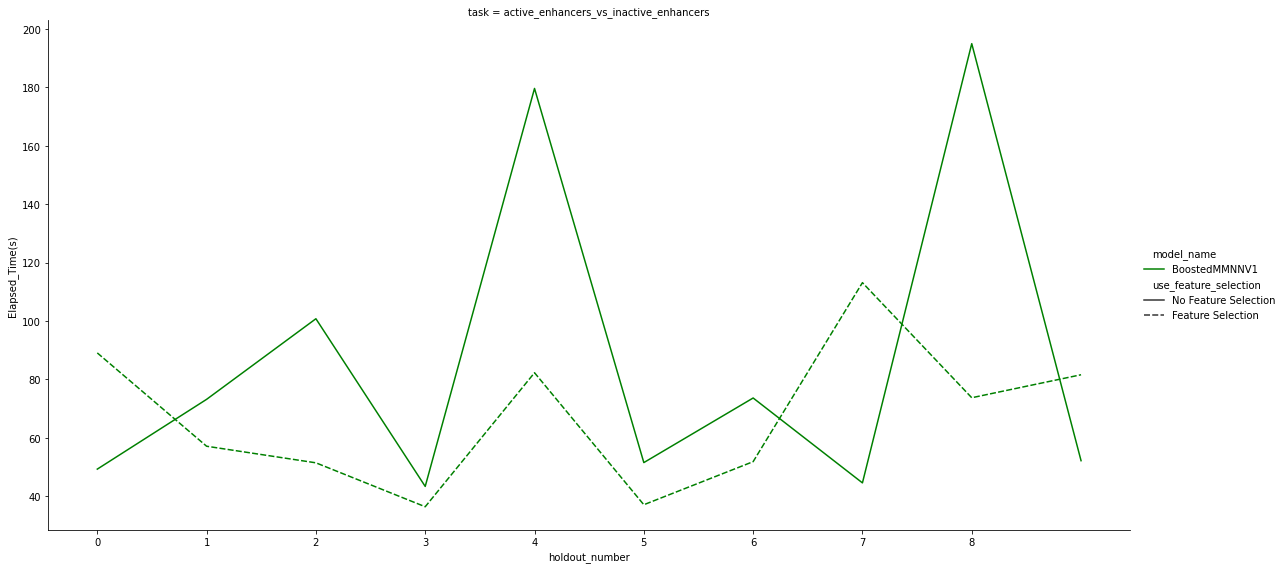

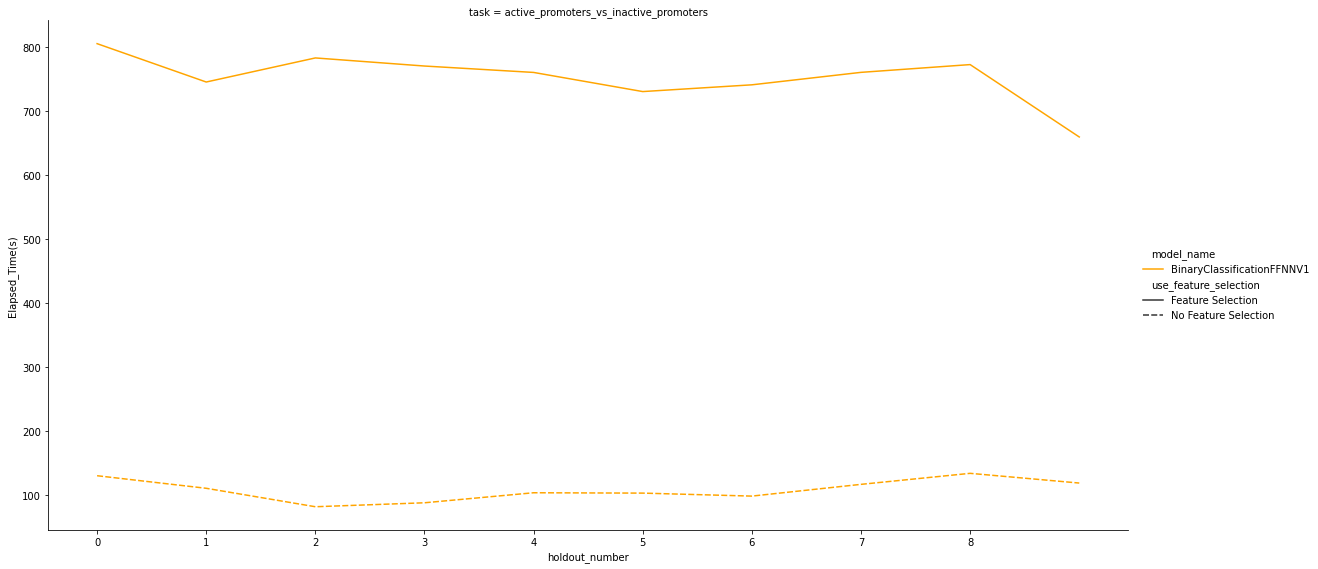

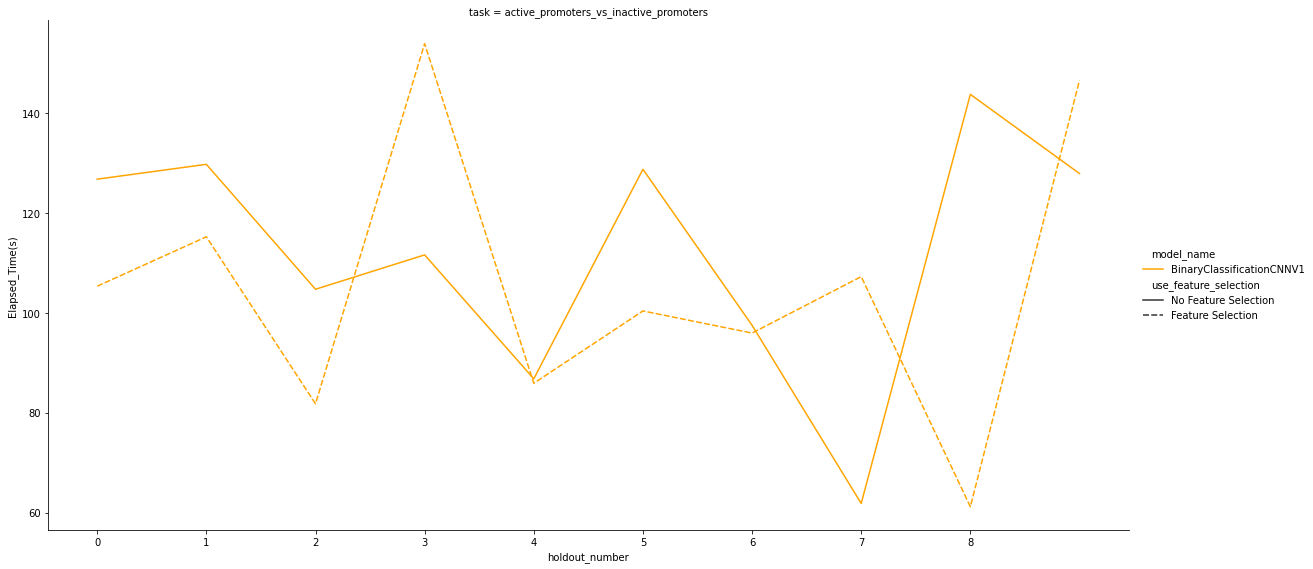

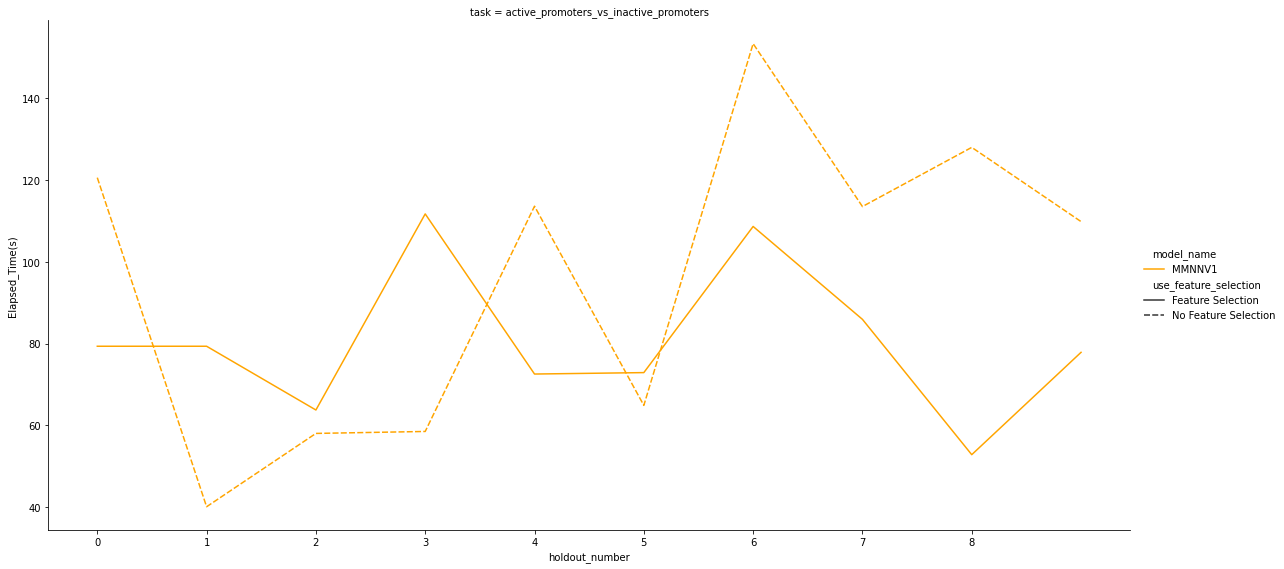

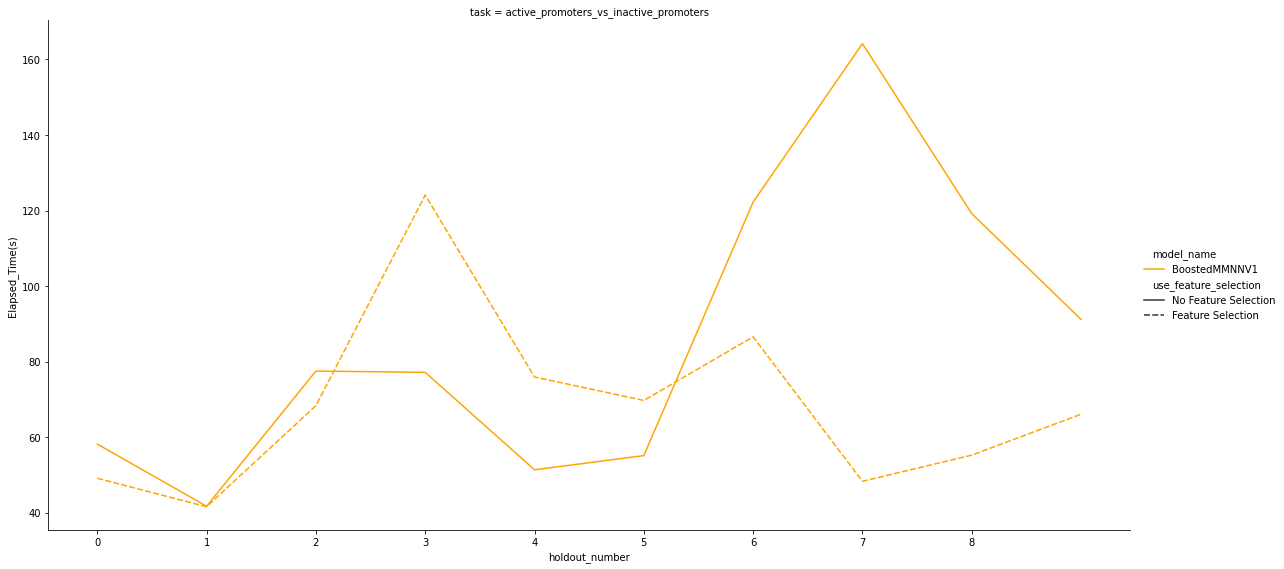

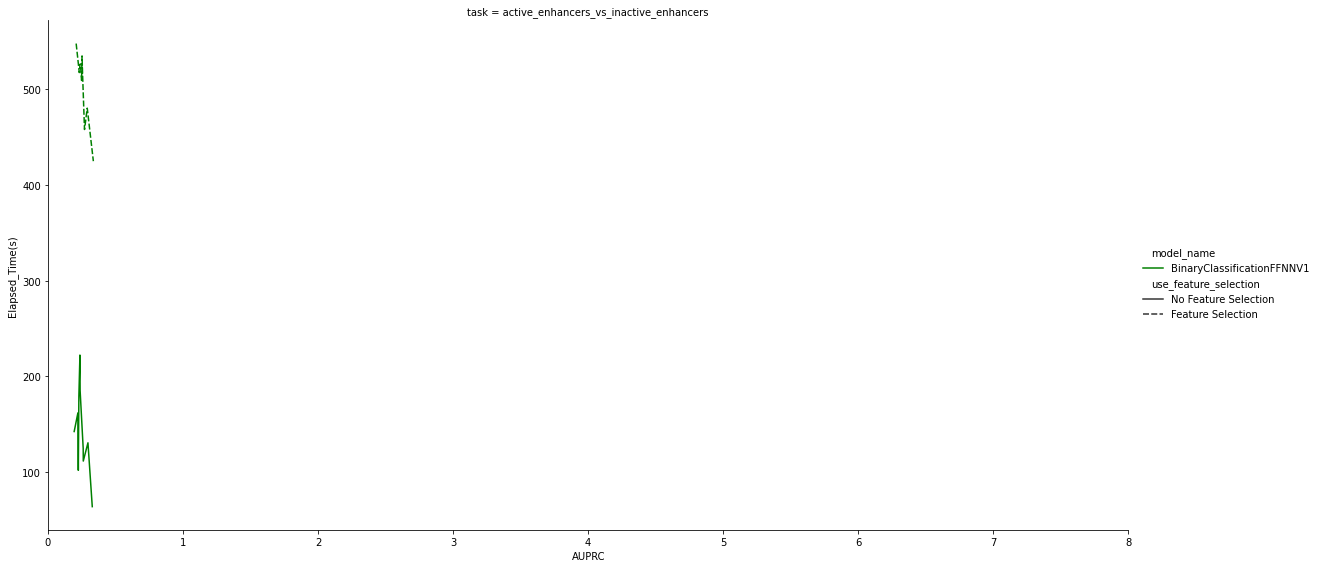

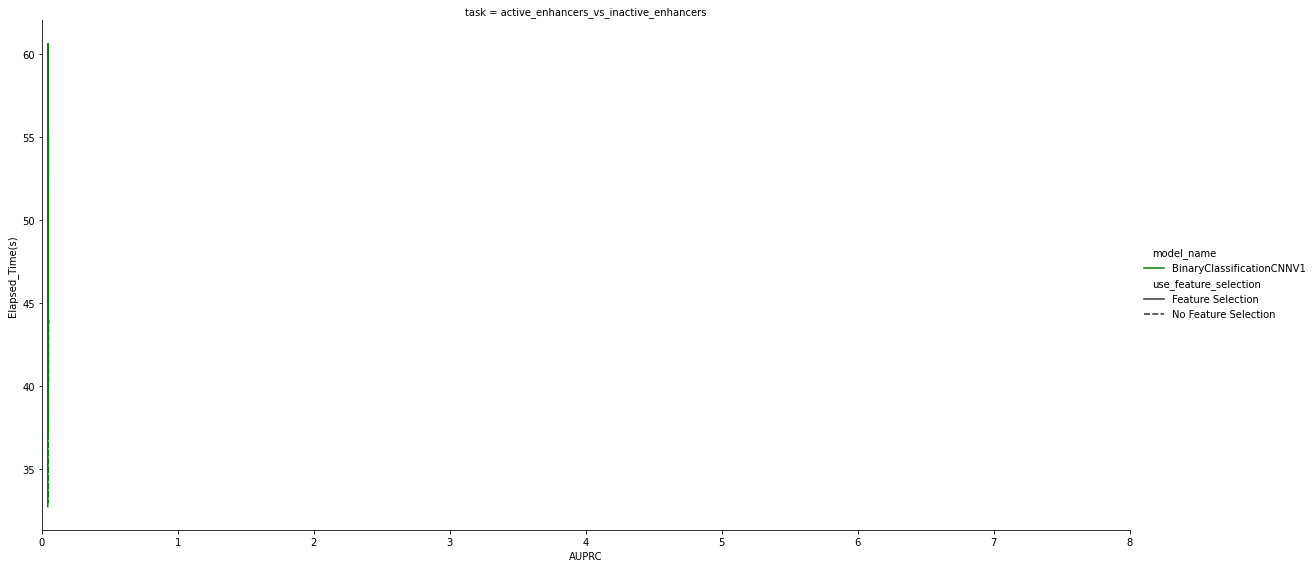

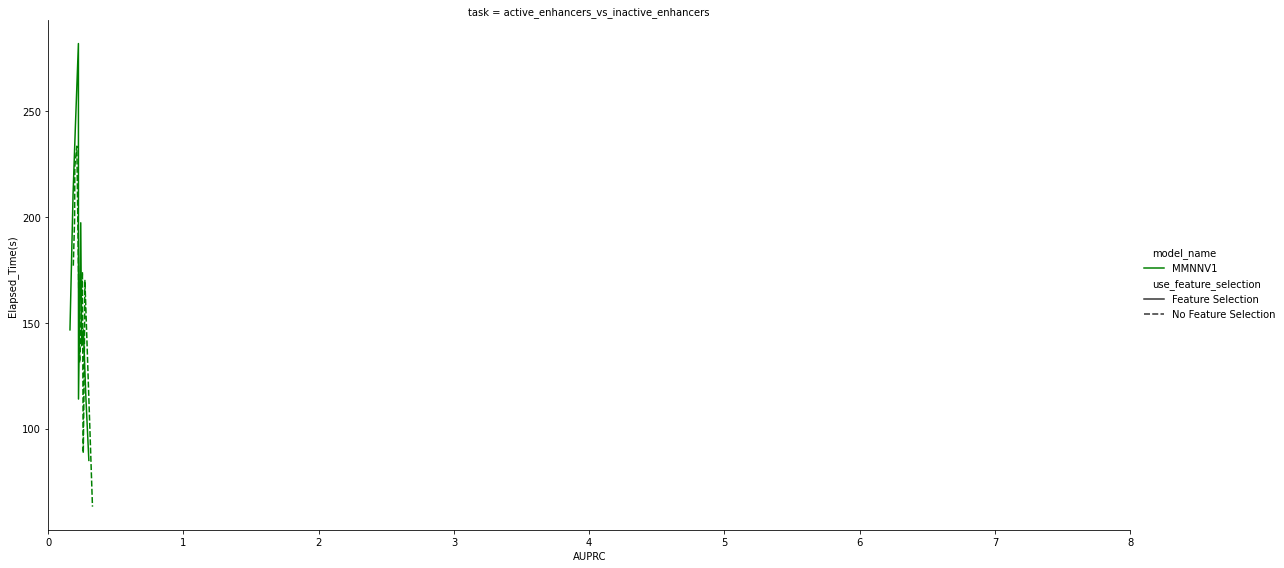

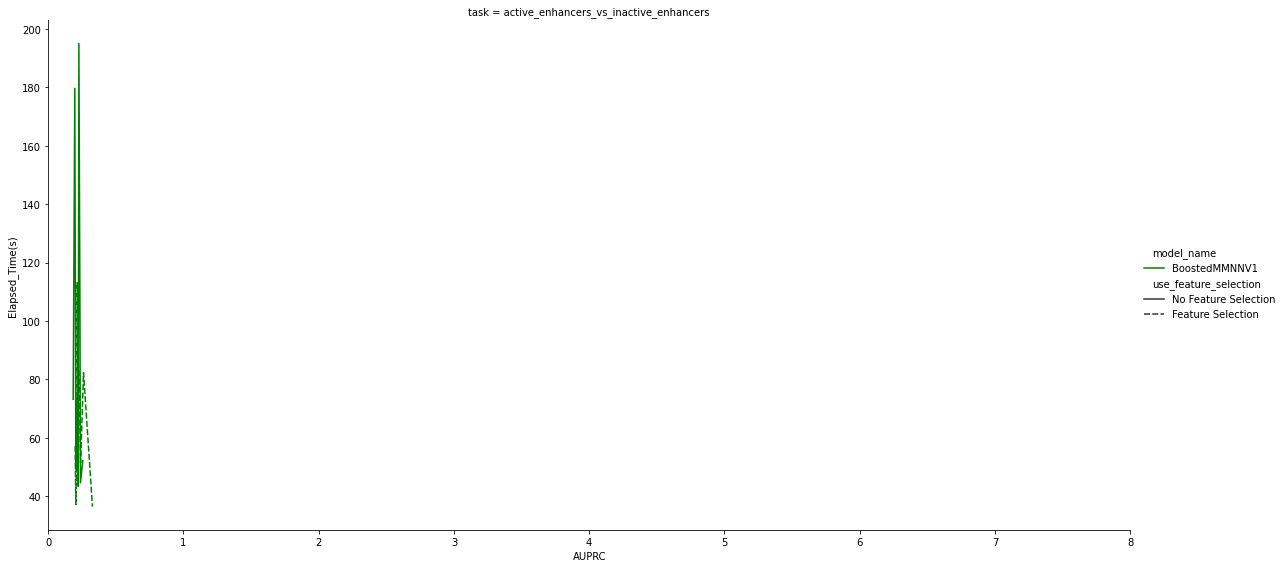

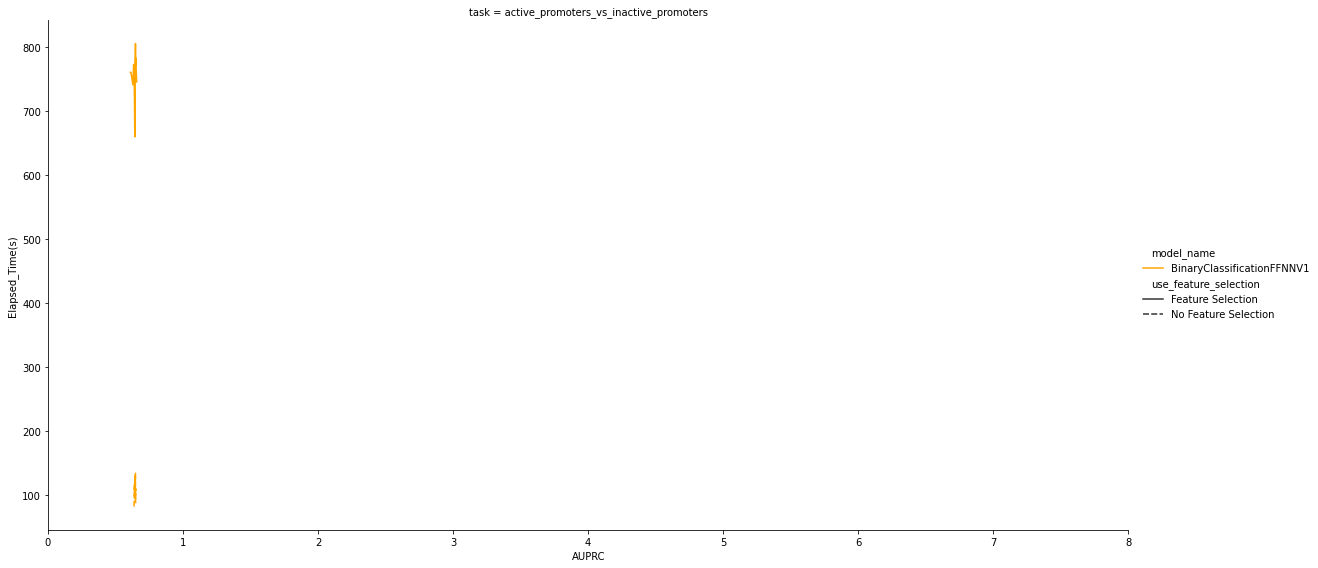

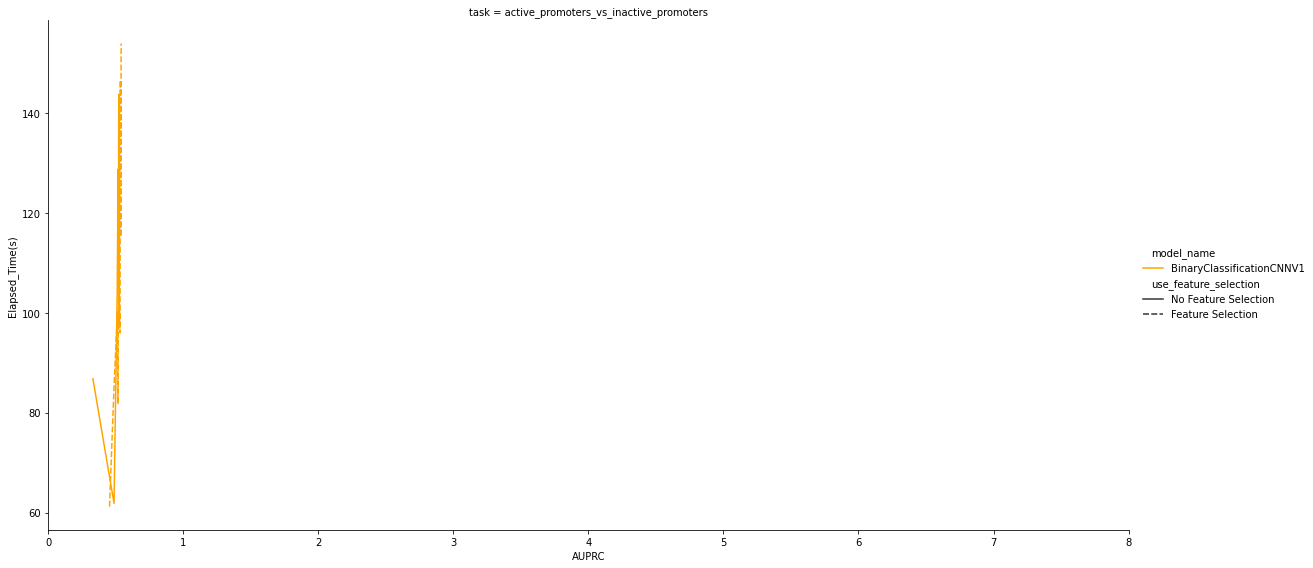

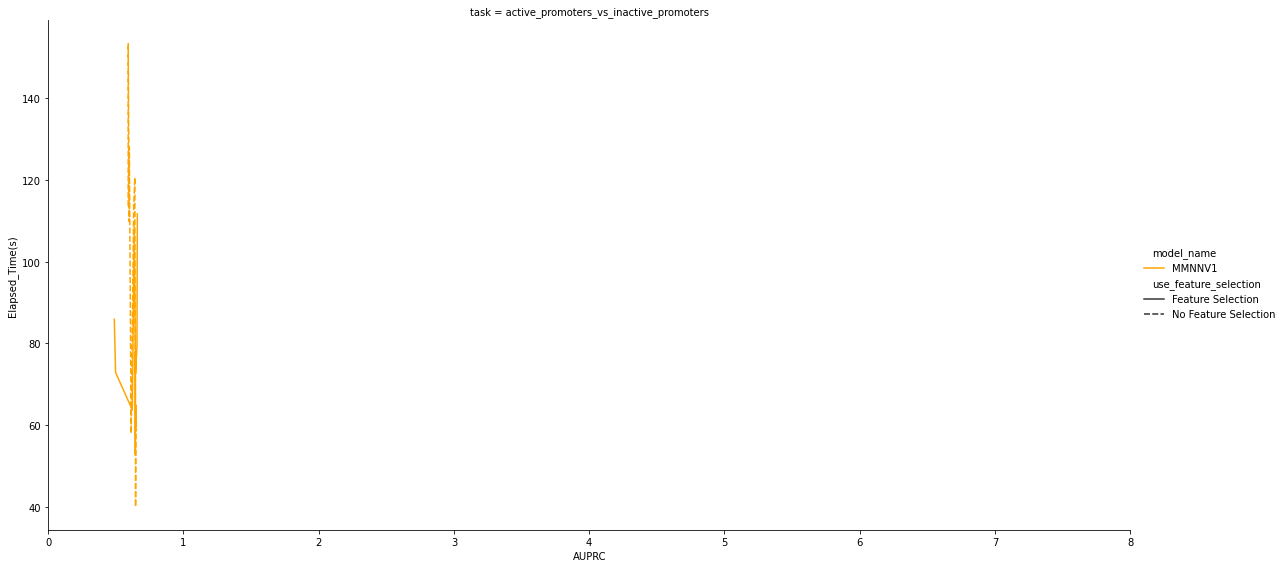

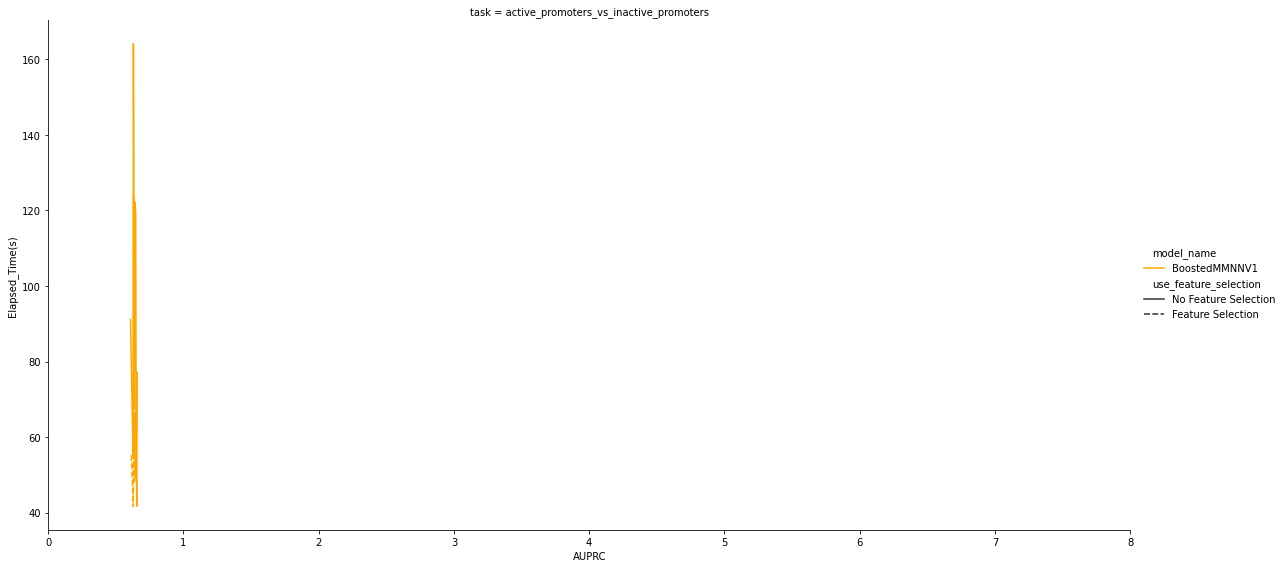

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

columns_to_eval = ["holdout_number", "AUPRC"]
for col in columns_to_eval:
    for task in all_binary_classification_performance.task.unique():
        for model in all_binary_classification_performance.model_name.unique():
            if task == "active_enhancers_vs_inactive_enhancers":
                palette = ["green"]
            else:
                palette = ["orange"]
            test_data_filtered = all_binary_classification_performance[
                (all_binary_classification_performance.run_type == 'test') & 
                (all_binary_classification_performance.model_name == model) & 
                (all_binary_classification_performance.task == task)].iloc[:, [5,27,28,29,30,31,32]].sort_values(by='AUPRC', ascending=True)
            relplot = sns.relplot(x=col, y="elapsed_time", hue="model_name", col="task", style="use_feature_selection", kind="line", data=test_data_filtered, aspect=2, height=8, palette=palette)
            if col == "holdout_number":
                val_min = min(all_binary_classification_performance.holdout_number)
                val_max = max(all_binary_classification_performance.holdout_number)
                relplot.set(xticks=np.arange(val_min, val_max, 1))
            relplot.set(ylabel='Elapsed_Time(s)')
            """
            directory = os.path.dirname(f"boruta_execution_analysis/{task}/{col}/{model}")
            if directory:
                os.makedirs(directory, exist_ok=True)
            relplot.savefig(f"boruta_execution_analysis/{task}/{col}/{model}.PNG")
            """

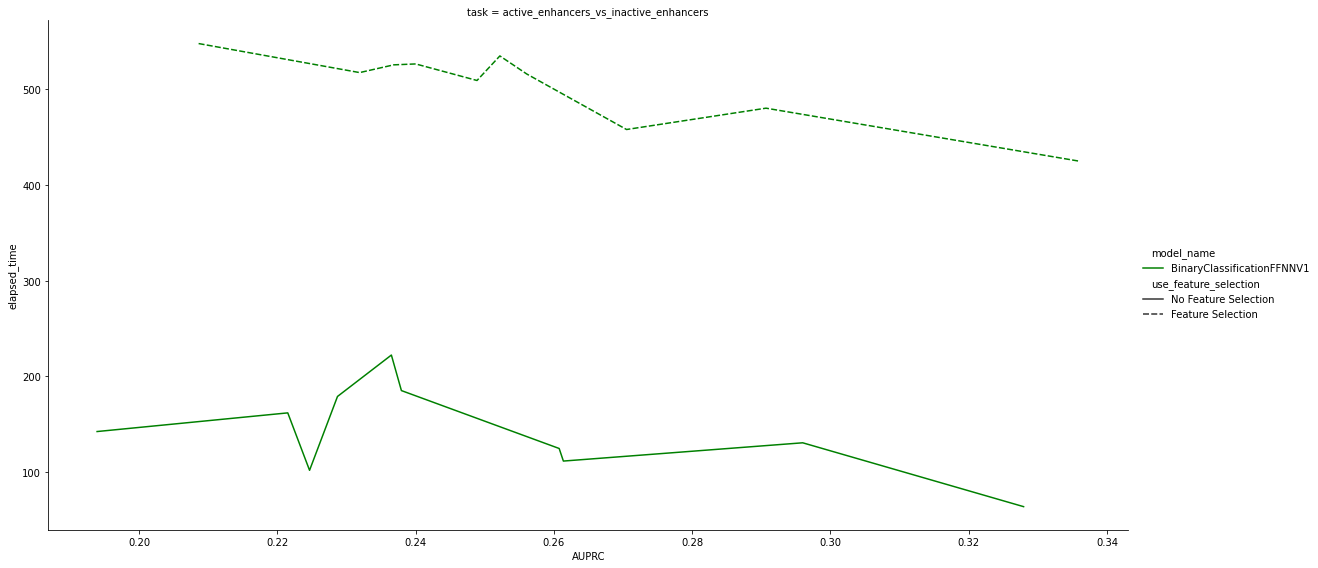

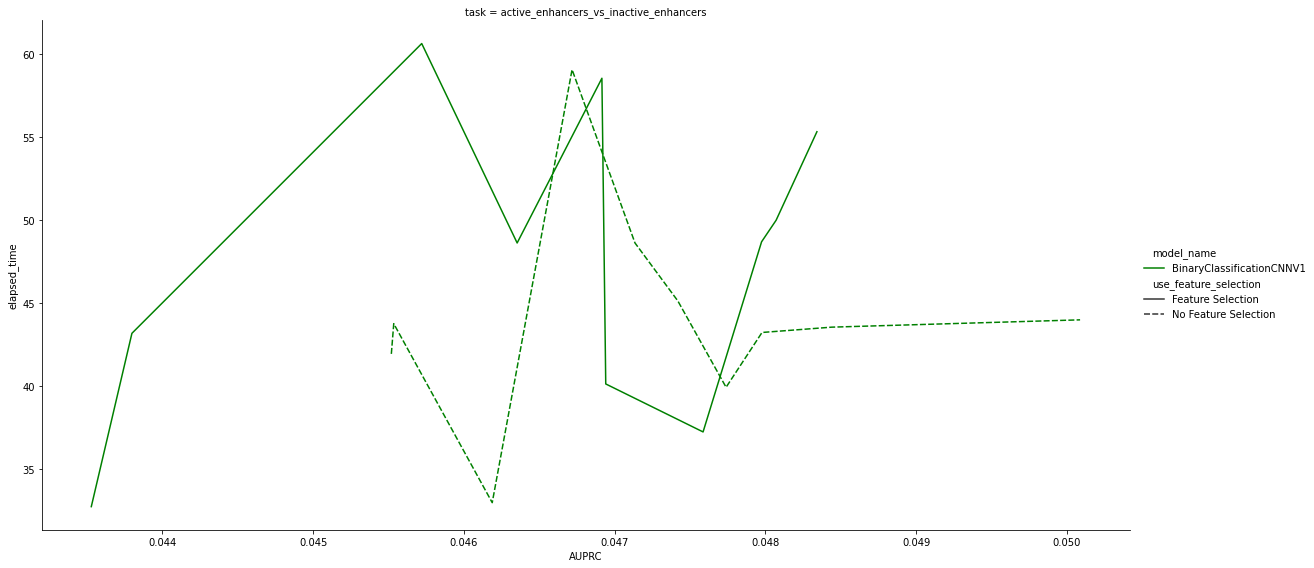

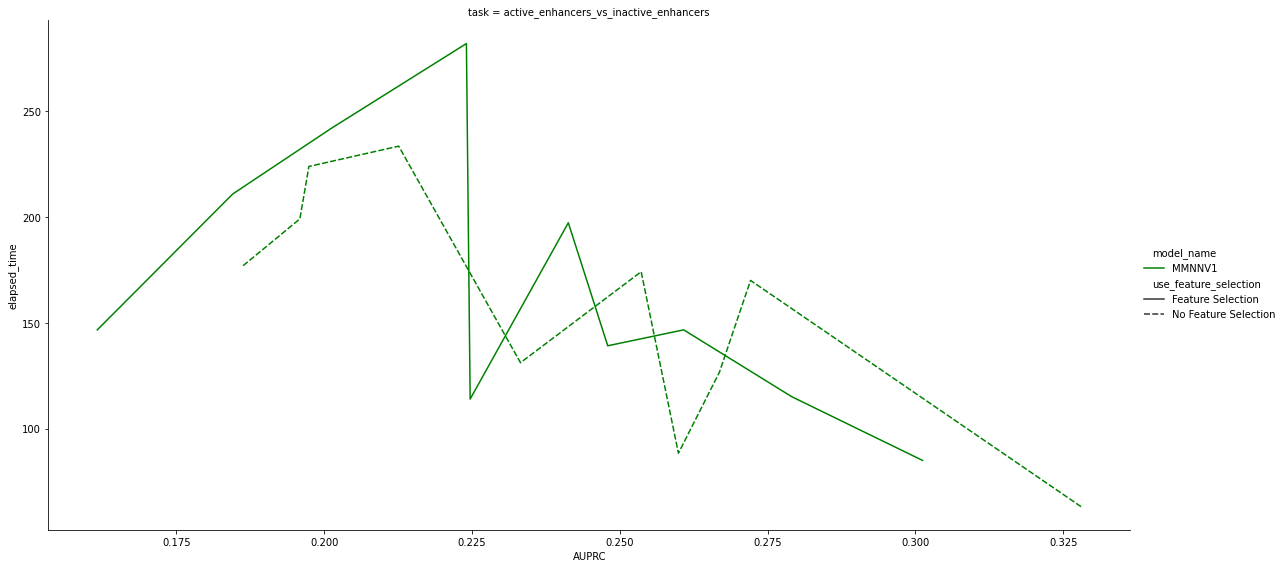

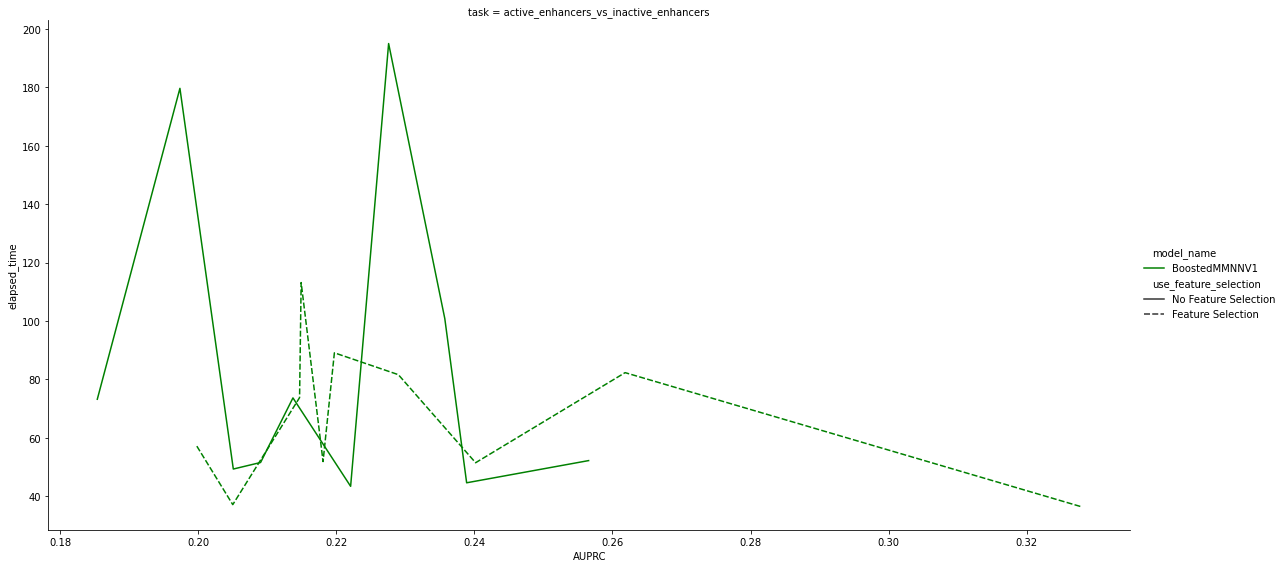

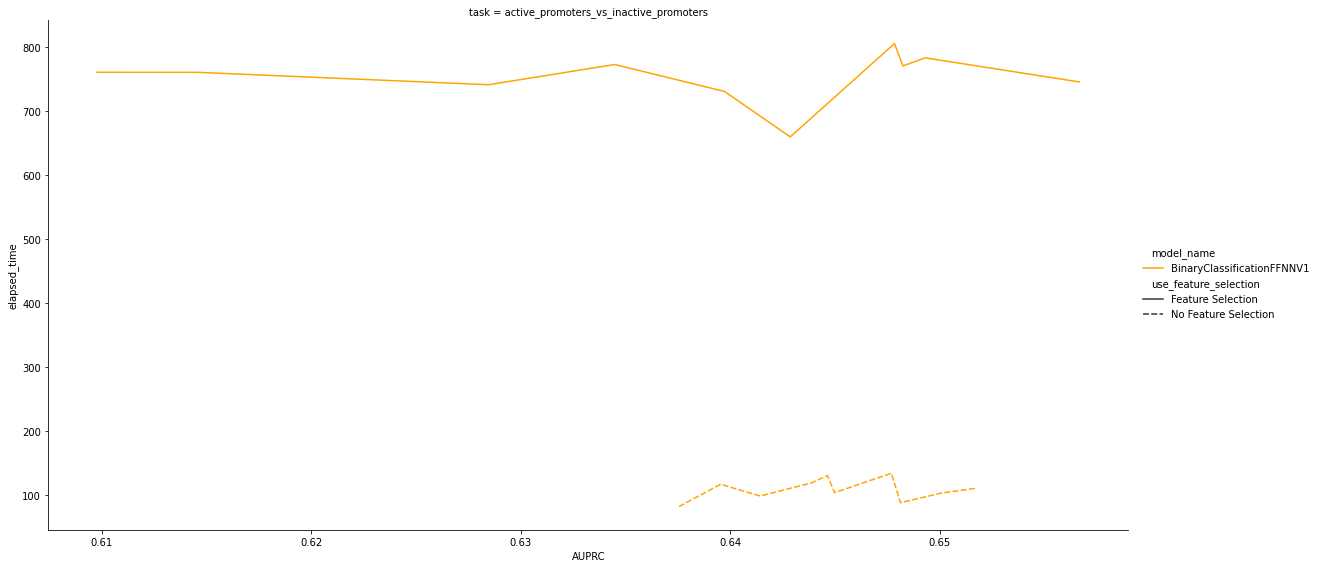

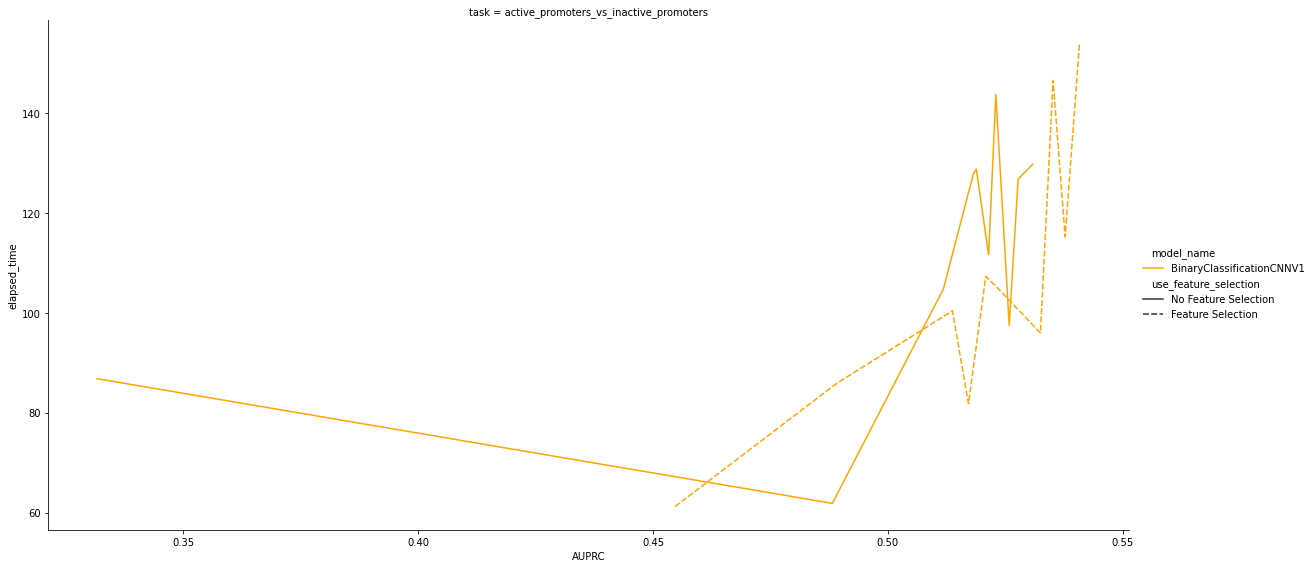

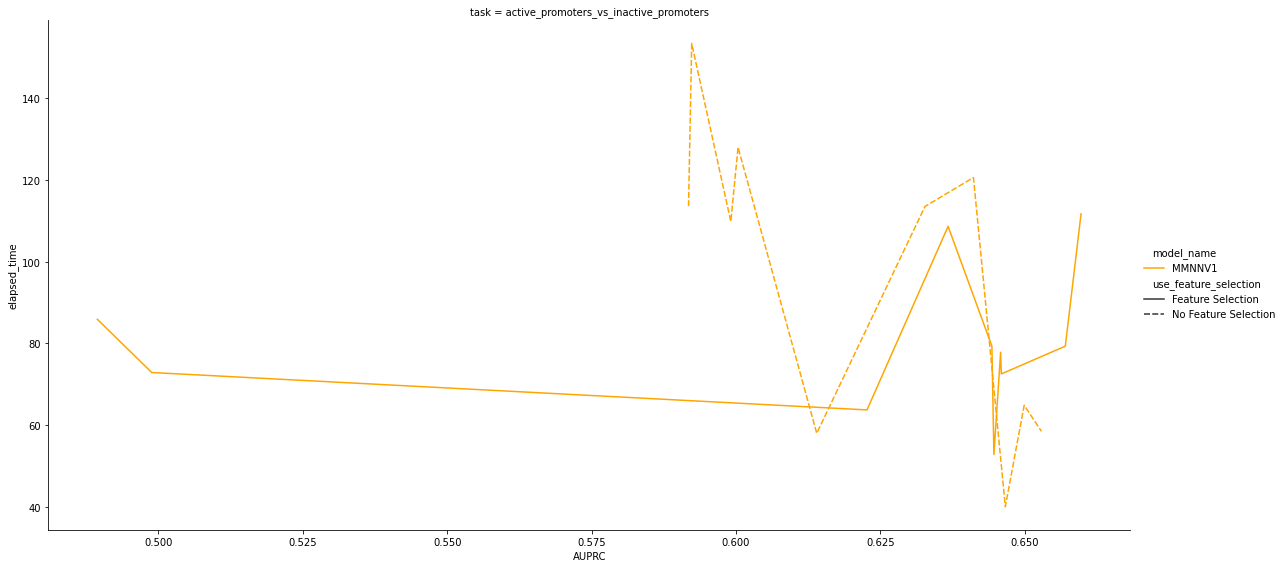

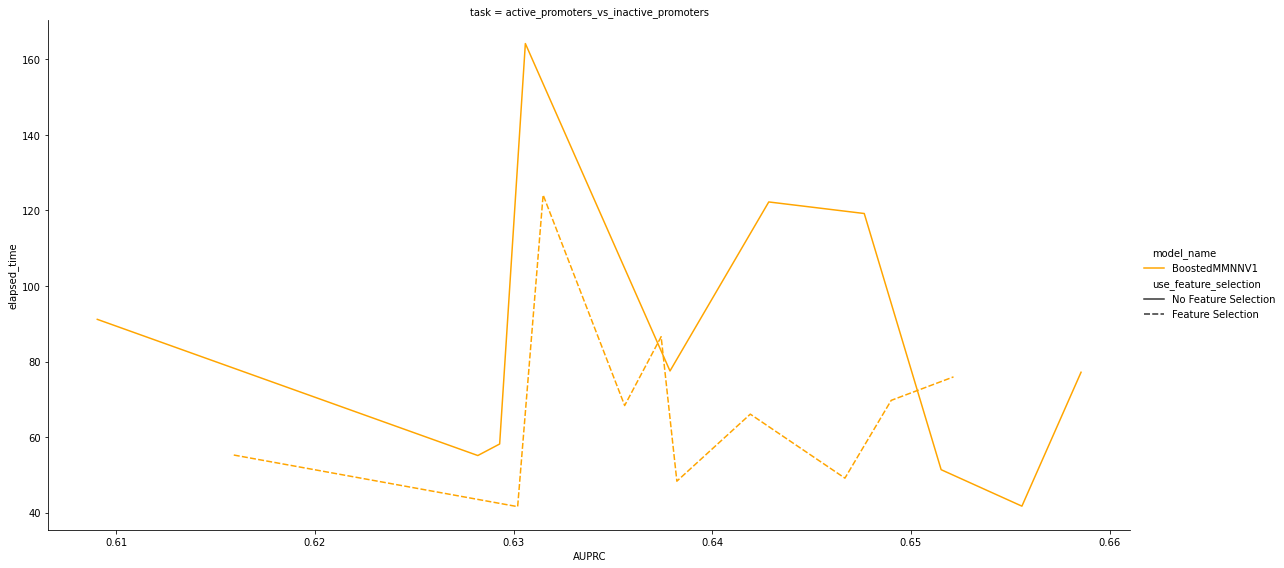

In [358]:
import seaborn as sns

for task in all_binary_classification_performance.task.unique():
    for model in all_binary_classification_performance.model_name.unique():
        if task == "active_enhancers_vs_inactive_enhancers":
            palette = ["green"]
        else:
            palette = ["orange"]
        test_data_filtered = all_binary_classification_performance[
            (all_binary_classification_performance.run_type == 'test') & 
            (all_binary_classification_performance.model_name == model) & 
            (all_binary_classification_performance.task == task)].iloc[:, [5,27,28,29,31,32]].sort_values(by='AUPRC', ascending=True)
        relplot = sns.relplot(x="AUPRC", y="elapsed_time", hue="model_name", col="task", style="use_feature_selection", kind="line", data=test_data_filtered, aspect=2, height=8, palette=palette)
        directory = os.path.dirname(f"boruta_execution_analysis/{task}/{model}")
        if directory:
            os.makedirs(directory, exist_ok=True)
        relplot.savefig(f"boruta_execution_analysis/{task}/{model}.PNG")